In [1]:
import matplotlib.pyplot as plt
plt.style.use(['classic'])
import astropy.coordinates as coord
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from astropy.io import fits
from scipy import stats
from scipy.stats import binned_statistic
from scipy.linalg import block_diag,eigh
plt.rcParams['font.family']='stixgeneral'
plt.rcParams.update({'font.size':16})
from astropy.io import fits
import ebf
import pdb
from mpl_toolkits.mplot3d import Axes3D
from astropy.coordinates import (CartesianRepresentation,CartesianDifferential)
from astropy.coordinates import Galactic
from astropy import units as u1
from astropy.coordinates import SkyCoord
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from itertools import groupby
import scipy.integrate as integrate
import scipy.special as special
from scipy.stats import poisson
from scipy.optimize import minimize
from random import choices
import scipy.stats as st
from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats
from scipy.integrate import simps

/Users/Jenny/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/Jenny/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/Jenny/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Running a galaxia simulation for halo17 with mag ranging from 14-20 mag, r < 1000 kpc, fsample 0.1, popID10.

In [2]:
satidflag = np.loadtxt('halo05_bound.txt')

In [3]:
time = np.loadtxt('halo05_bound_time.txt')

In [4]:
def make_csv(data_name, deg, num, particle):  # string, float (rotation angle in degrees)


    rot = deg * np.pi / 180.  # angle in radians

    data = ebf.read(data_name + '.ebf')  # reads in ebf file for galaxia output
    df = pd.DataFrame()  # creates empty pandas DataFrame

    keys = data.keys()  # creates list of keys for the ebf file

    if particle == True:
        cut = (data['grav'] < 2.5)
    else:
        cut = ()
    flag = np.unique(data['satid'])[np.where(satidflag == 0)]
    # print (keys)
    # for ii in range(1,len(list(data.keys()))): #for each list in the ebf file, create a dataframe column with that key as a column name
    # s=pd.Series(data[name])
    # print (s)

    # df[list(data.keys())[ii]]=data[list(data.keys())[ii]]
    # print (s)

    index = range(0, len(data['smass'][cut][np.isin(data['satid'][cut], flag)]), 1)
    #indexi = np.random.choice(index, num, replace=False)
    
    ac_time = []
    for ii in range(0,len(np.unique(data['satid']))):
        ac_time.append(np.repeat(time[ii],len(data['satid'][data['satid']==np.unique(data['satid'])[ii]])))
    
    df['ac_time'] = np.concatenate(ac_time)[cut][np.isin(data['satid'][cut], flag)]
    
    df['smass'] = data['smass'][cut][np.isin(data['satid'][cut], flag)]

    df['age'] = data['age'][cut][np.isin(data['satid'][cut], flag)]
    df['rad'] = data['rad'][cut][np.isin(data['satid'][cut], flag)]

    df['mag0'] = data['mag0'][cut][np.isin(data['satid'][cut], flag)]
    df['mag1'] = data['mag1'][cut][np.isin(data['satid'][cut], flag)]
    df['mag2'] = data['mag2'][cut][np.isin(data['satid'][cut], flag)]
    df['popid'] = data['popid'][cut][np.isin(data['satid'][cut], flag)]
    df['satid'] = data['satid'][cut][np.isin(data['satid'][cut], flag)]
    # df['fieldid']=data['fieldid']
    # df['partid']=data['partid']
    # df['center']=data['center']
    df['lum'] = data['lum'][cut][np.isin(data['satid'][cut], flag)]
    df['teff'] = data['teff'][cut][np.isin(data['satid'][cut], flag)]

    # set original output positions and velocities as xx_0. These are in the unrotated frame where x-axis does not always point to galactic center
    df['glon_0'] = data['glon'][cut][np.isin(data['satid'][cut], flag)]
    df['glat_0'] = data['glat'][cut][np.isin(data['satid'][cut], flag)]
    df['px_0'] = data['px'][cut][np.isin(data['satid'][cut], flag)]
    df['py_0'] = data['py'][cut][np.isin(data['satid'][cut], flag)]
    df['pz_0'] = data['pz'][cut][np.isin(data['satid'][cut], flag)]
    df['vx_0'] = data['vx'][cut][np.isin(data['satid'][cut], flag)]
    df['vy_0'] = data['vy'][cut][np.isin(data['satid'][cut], flag)]
    df['vz_0'] = data['vz'][cut][np.isin(data['satid'][cut], flag)]

    # print (df['glon_0'],df['glon'])

    # set outputs by rotating so x-axis points to galactic center
    df['glon'] = (df['glon_0'] - deg) % 360
    df['glat'] = df['glat_0']
    df['px'] = df['px_0'] * np.cos(rot) + df['py_0'] * np.sin(rot)
    df['py'] = -df['px_0'] * np.sin(rot) + df['py_0'] * np.cos(rot)
    df['pz'] = df['pz_0']
    df['vx'] = df['vx_0'] * np.cos(rot) + df['vy_0'] * np.sin(rot)
    df['vy'] = -df['vx_0'] * np.sin(rot) + df['vy_0'] * np.cos(rot)
    df['vz'] = df['vz_0']

    # set original center values
    o_cen = np.full(len(df['glon']), np.nan)

    o_cen[0:6] = [-8.0, 0.0, 0.015, 11.1, 239.08, 7.25]
    df['orig_center'] = o_cen

    df.to_csv(data_name + 'boundnew.csv', index=False)  # save as CSV with same base name that can be opened in python 3
    return df




In [5]:
testd = make_csv('halo05', 0,30000,True)

In [6]:
def get_coord_obj_rot(data): #pandas DataFrame
    import astropy
    import astropy.coordinates as coord
    import astropy.units as u
    import numpy as np
    x=data['px'].values#full sets in heliocentric coords
    y=data['py'].values
    z=data['pz'].values
    vx=data['vx'].values
    vy=data['vy'].values
    vz=data['vz'].values
    
    v_sun_gc=[data['orig_center'][3], data['orig_center'][4], data['orig_center'][5]] #galactocentric sun coordinates, based on original heliocentric x-axis aligned with galactocentric X-axis

    gal=coord.SkyCoord(u=x*u.kpc, v=y*u.kpc, w=z*u.kpc, #galactic frame cartesian coordinate object
                       U=vx*u.km/u.s, V=vy*u.km/u.s, W=vz*u.km/u.s, frame='galactic', 
                       representation_type='cartesian', differential_type='cartesian')
    gal.representation_type='spherical' #change type to spherical (l, b, proper motions, rad vel, etc)
    gal.differential_type=coord.representation.SphericalCosLatDifferential

    return gal #return coordinate object

#TURNS A DATAFRAME OF STARS INTO ASTROPY COORDINATE OBJECT, GALACTIC FRAME (HELIOCENTRIC X-AXIS TO GC), TAKING INTO ACCOUNT THE SOLAR REFLEX MOTION
def get_coord_obj_rot_gsr(data):
    import astropy
    import astropy.coordinates as coord
    import astropy.units as u
    import numpy as np
    x=data['px'].values#full sets in heliocentric coords
    y=data['py'].values
    z=data['pz'].values
    vx=data['vx'].values
    vy=data['vy'].values
    vz=data['vz'].values
    # v_sun_gl=[data['center'][3], data['center'][4], data['center'][5]]
    v_sun_gc=[11.1, 239.08, 7.25] #galactocentric sun coordinates
    v_sun=coord.CartesianDifferential(v_sun_gc*u.km/u.s) #turn into a coordinate cartesian differential
    
   
    gal=coord.SkyCoord(u=x*u.kpc, v=y*u.kpc, w=z*u.kpc,
                       U=(vx+v_sun_gc[0])*u.km/u.s, V=(vy+v_sun_gc[1])*u.km/u.s, W=(vz+v_sun_gc[0])*u.km/u.s, frame='galactic',
                       representation_type='cartesian', differential_type='cartesian') #adds solar velocity to star velocity for calculating gsr frame parameters
    
    gal.representation_type='spherical' #convert to spherical representation (l, b, distance)
    
    gal.differential_type=coord.representation.SphericalCosLatDifferential #convert differentials to spherical cos lat (proper motions, radial velocity)
    print (gal)
    return gal

#takes an angle and returns corresponding angle within limits. If no minparam give, returns angle between (0,2*pi)/(0,360)
#if minval is given returns angle between (minval, minval+2*pi)/(minval, minval+360). Ex if minval=-pi, range will be (-pi, pi)
def limrange(angle, *minparam, **degflag):    #float, float, bool (deg=True/False)
    import numpy as np
    if len(minparam) == 0: minval = 0.0
    else: minval = minparam[0]
    
    if ('deg' in degflag):
        newangle = (angle-minval)%(360.0)+minval
    else:   
        newangle = (angle-minval)%(2.0*np.pi)+minval
        
    return newangle

#add radial velocity, l, b, dist, proper motions, v_gsr, pm_gsr, v_t, v_t_gsr, dist modulus to CSV
def rv_csv(halo, field, deg): #string, string, int
    import pandas as pd
    import numpy as np
    #NAME OF CSV FILE
    if deg%1==0: #if deg is integer use make string
        d=str(int(deg))
    else:
        d="{0:.2f}".format(deg) #else round to 2 decimals and make string
    data_name=halo+'/'+d+'/'+field+'/'+halo+'_'+field+'_'+d
    #OPEN CSV
    data=pd.read_csv(data_name+'.csv')
    #GALACTOCENTRIC SOLAR VELOCITY WITH SUN ON X-AXIS
    v_sun_gc=[11.1, 239.08, 7.25]
    #CREATE ASTROPY COORD OBJECT
    gal=get_coord_obj_rot(data)
    gal_gsr=get_coord_obj_rot_gsr(data)
    #ASSIGN TO DATAFRAME
    data=data.assign(l_coord=gal.l.degree)
    data=data.assign(b_coord=gal.b.degree)
    data=data.assign(pm_l_cosb=gal.pm_l_cosb)
    data=data.assign(pm_b=gal.pm_b)
    data=data.assign(pm_mag=np.sqrt(np.add(np.square(data.pm_b),np.square(data.pm_l_cosb))))
    data=data.assign(r_v=gal.radial_velocity)
    data=data.assign(dist=gal.distance)
    data=data.assign(dm=5.*np.log10(gal.distance.value*1000.)-5.)
    data=data.assign(v_l=4.74047*gal.pm_l_cosb*gal.distance)
    data=data.assign(v_b=4.74047*gal.pm_b*gal.distance)
    data=data.assign(v_t=np.sqrt(np.add(np.square(data.v_l),np.square(data.v_b))))
    data=data.assign(pm_l_cosb_gsr=gal_gsr.pm_l_cosb)
    data=data.assign(pm_b_gsr=gal_gsr.pm_b)
    data=data.assign(pm_mag_gsr=np.sqrt(np.add(np.square(data.pm_b_gsr),np.square(data.pm_l_cosb_gsr))))
    data=data.assign(v_gsr=gal_gsr.radial_velocity)
    data=data.assign(v_l_gsr=4.74047*gal_gsr.pm_l_cosb*gal_gsr.distance)
    data=data.assign(v_b_gsr=4.74047*gal_gsr.pm_b*gal_gsr.distance)
    data=data.assign(v_t_gsr=np.sqrt(np.add(np.square(data.v_l_gsr),np.square(data.v_b_gsr))))
    #SAVE NEW CSV WITH SAME NAME TO REPLACE
    data.to_csv(data_name+'.csv', index=False)
    



In [7]:
rad_t = get_coord_obj_rot_gsr(testd)

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
    [( 51.71867105,  31.20697577, 120.86799544),
     ( 51.45693775,  30.53204043, 122.39774989),
     (311.95340427, -27.04344667, 198.0386341 ), ...,
     (310.2986417 ,  13.832537  ,  10.84033573),
     (  1.47427797,  -0.13317201,   8.09143589),
     (359.45734111,   1.54216686,   7.62506391)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-0.07968193, -0.02886659,   94.03423732),
     (-0.07362828, -0.02519215,   91.26573323),
     (-0.03972131, -0.01727176,   33.64242405), ...,
     (-2.34647195,  1.86477484,  127.94707743),
     (-1.25620114, -7.36156065,  310.34115371),
     ( 5.12667585,  0.38217598, -155.30581552)]>


In [8]:
gctest = get_coord_obj_rot(testd)

In [9]:
rad_t

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
    [( 51.71867105,  31.20697577, 120.86799544),
     ( 51.45693775,  30.53204043, 122.39774989),
     (311.95340427, -27.04344667, 198.0386341 ), ...,
     (310.2986417 ,  13.832537  ,  10.84033573),
     (  1.47427797,  -0.13317201,   8.09143589),
     (359.45734111,   1.54216686,   7.62506391)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-0.07968193, -0.02886659,   94.03423732),
     (-0.07362828, -0.02519215,   91.26573323),
     (-0.03972131, -0.01727176,   33.64242405), ...,
     (-2.34647195,  1.86477484,  127.94707743),
     (-1.25620114, -7.36156065,  310.34115371),
     ( 5.12667585,  0.38217598, -155.30581552)]>

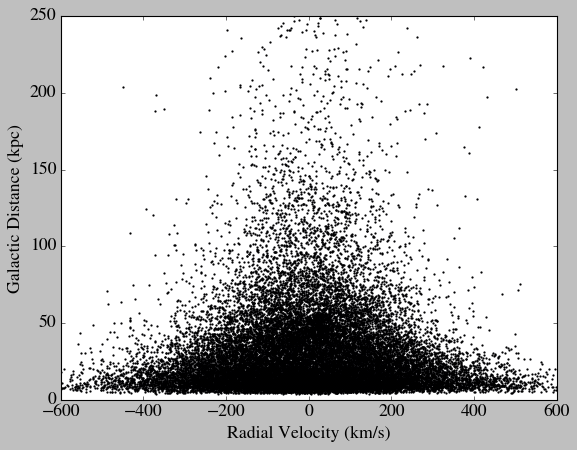

In [10]:
#plotting distance versus vrad (compared to Bullock 2005)

plt.scatter(rad_t.radial_velocity/u1.km*u1.s,testd['rad'],s=1,c='b')
plt.ylabel('Galactic Distance (kpc)')
plt.xlabel('Radial Velocity (km/s)')
plt.xlim(-600,600)
plt.ylim(0,250)
plt.show()
plt.show()

In [11]:
rad_t = get_coord_obj_rot_gsr(testd)
gc1 = rad_t.transform_to(coord.Galactocentric)
r2= np.sqrt(gc1.x**2+gc1.y**2+gc1.z**2)



# Function for calculating the space separation and the velocity difference in each shell



zmin = 20
zmax = 100
zlim = 4.

ra = r2/u1.kpc
r2= ra

vral = rad_t.radial_velocity/u1.km*u1.s
groupidi = range(0,len(testd))


# cutting r and z > 20 & r < 60 kpc stars
df1=pd.DataFrame()
df2=pd.DataFrame()
df3 = pd.DataFrame()
df1['x']=gc1.x[ (zmin < r2 ) & (r2 < zmax ) ]
df1['y']=gc1.y[ (zmin < r2 ) & (r2< zmax ) ]
df1['z']=gc1.z[ (zmin < r2 ) & (r2 < zmax ) ]
df1['Vgal']= vral[ (zmin <r2 ) & (r2 < zmax ) ]
df1['r']= r2[ (zmin < r2) & (r2 < zmax )]
df1['starid']= np.array(groupidi)[ (zmin < r2) & (r2 < zmax )]
df1['index']= np.arange(0,len(df1['r']),1)
df1['time']= testd['ac_time'][ (zmin < r2 ) & (r2 < zmax ) ].values
#print (df1['index'])
df2['r']=df1['r'][(np.absolute(df1['z']) > zlim)]
df2['x']=df1['x'][(np.absolute(df1['z']) > zlim)]
df2['y']=df1['y'][(np.absolute(df1['z']) > zlim) ]
df2['z']=df1['z'][(np.absolute(df1['z']) > zlim)]
df2['Vgal']= df1['Vgal'][(np.absolute(df1['z']) > zlim)]
df2['starid']= df1['starid'][(np.absolute(df1['z']) > zlim)]
#df2['age']= df1['age'][(np.absolute(df1['z']) > zlim)]
df2['index']= np.arange(0,len(df2['r']),1)
df2['time']= df1['time'][(np.absolute(df1['z']) > zlim)]

df3 = df2.sort_values(by=['index'])

#df3 = df3.sample(n = 10000)

#df3.to_csv("df3_10000_halo12_grav2.5.csv")

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
    [( 51.71867105,  31.20697577, 120.86799544),
     ( 51.45693775,  30.53204043, 122.39774989),
     (311.95340427, -27.04344667, 198.0386341 ), ...,
     (310.2986417 ,  13.832537  ,  10.84033573),
     (  1.47427797,  -0.13317201,   8.09143589),
     (359.45734111,   1.54216686,   7.62506391)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-0.07968193, -0.02886659,   94.03423732),
     (-0.07362828, -0.02519215,   91.26573323),
     (-0.03972131, -0.01727176,   33.64242405), ...,
     (-2.34647195,  1.86477484,  127.94707743),
     (-1.25620114, -7.36156065,  310.34115371),
     ( 5.12667585,  0.38217598, -155.30581552)]>


In [12]:
def asSpherical(x,y,z):
    #takes list xyz (single coord)
    
    r       =  np.sqrt(x*x + y*y + z*z)
    print (r,z)
    theta   = np.arccos(z/r)*180/ np.pi #to degrees
    phi     =  np.arctan2(y,x)*180/ np.pi
    return [r,theta,phi]

In [13]:
sphere = asSpherical(df3['x'].values,df3['y'].values,df3['z'].values)
df3['theta']=sphere[1]
df3['phi']=sphere[2]
df4 = pd.DataFrame()
df4['r']=df3['r']
df4['x']=df3['x']
df4['y']=df3['y']
df4['z']=df3['z']
df4['starid']= df3['starid']
df4['index']= df3['index']
df4['phi']= df3['phi']
df4['theta']= df3['theta']
df4['Vgal'] = np.random.permutation(df3['Vgal'].values)

[97.91955886 91.60252823 99.97457645 ... 48.07695967 35.98813062
 66.44253806] [ 49.13509006  47.10369659 -15.31018936 ...  11.08400952  -8.84308352
  41.45331846]


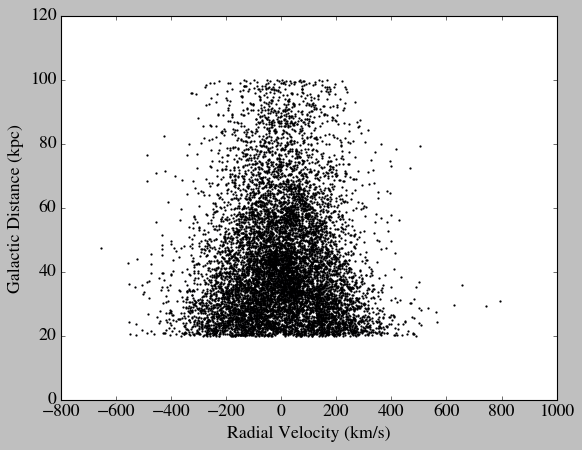

In [14]:
#plotting distance versus vrad (compared to Bullock 2005)

plt.scatter(df3['Vgal'],df3['r'],s=1,c='b')
plt.ylabel('Galactic Distance (kpc)')
plt.xlabel('Radial Velocity (km/s)')
#plt.xlim(-600,600)
#plt.ylim(0,250)
plt.show()
plt.show()

In [18]:
import math

# Velocity dispersion

In [27]:
class Comp:
    def __init__(self, x, y, z, rv, groupid):
        '''
        class for the input of the correlation function
        :param x: x position for the target
        :param y: y position for the target
        :param z: z position for the target
        :param rv: radial velocity for the target

        '''

        self.x = np.array(x)
        self.y = np.array(y)
        self.z = np.array(z)
        self.rv = np.array(rv)
        self.groupid = np.array(groupid)


def v_diff_patch_2(spaces, data,  times):
    '''
        :param spaces: Scale for space sparation
        :param data: The orginal dataset
        :param interval: raidal space interval for the shell of calculating the space separation


    '''

    
    numf = []
   
    zmini = [20, 32, 44, 56]
    zmaxi = [32, 44, 56, 90]
    vdiffhff=[]
        # print (vdiffhf)
    spectff=[]
    indexoutff=[]
    frac = []
    
    for ii in range(0, 4, 1):
        
        vdiffhf = []
        rlim = []
        spectf = []
        indexoutf = []
        num=[]
        if ii < 3:
            rlim.append(zmini[ii])
            zmin = zmini[ii]
            zmax = zmaxi[ii]
            deg = math.degrees(math.atan(math.tan(12/20)))
            dfx = pd.DataFrame()
            dfxf = pd.DataFrame()
        
            dfx['x'] = data['x'][(zmin < data['r']) & (data['r'] < zmax)]
        # print (dfx['x'])
            dfx['y'] = data['y'][(zmin < data['r']) & (data['r'] < zmax)]
            dfx['z'] = data['z'][(zmin < data['r']) & (data['r'] < zmax)]
            dfx['Vgal'] = data['Vgal'][(zmin < data['r']) & (data['r'] < zmax)]
            dfx['index'] = data['index'][(zmin < data['r']) & (data['r'] < zmax)]
            dfx['theta'] = data['theta'][(zmin < data['r']) & (data['r'] < zmax)]
            dfx['phi'] = data['phi'][(zmin < data['r']) & (data['r'] < zmax)]

            dfx['r'] = data['r'][(zmin < data['r']) & (data['r'] < zmax)]
            degstheta = np.arange(0,180,deg)
            degsphi = np.arange(-180,180,deg)
        
     
            for jj in range(1,len(degstheta)):
                for kk in range(1,len(degsphi)):
                    dfxi = pd.DataFrame()
                    dfxi['Vgal'] = dfx['Vgal'][(degstheta[jj-1] < dfx['theta']) & (dfx['theta'] < degstheta[jj])& (dfx['phi'] > degsphi[kk-1])& (dfx['phi'] < degsphi[kk])]
                    dfxi['index'] = dfx['index'][(degstheta[jj-1] < dfx['theta']) & (dfx['theta'] < degstheta[jj])& (dfx['phi'] > degsphi[kk-1])& (dfx['phi'] < degsphi[kk])]
                    dfxi['x'] = dfx['x'][(degstheta[jj-1] < dfx['theta']) & (dfx['theta'] < degstheta[jj])& (dfx['phi'] > degsphi[kk-1])& (dfx['phi'] < degsphi[kk])]
        # print (dfx['x'])
                    dfxi['y'] = dfx['y'][(degstheta[jj-1] < dfx['theta']) & (dfx['theta'] < degstheta[jj])& (dfx['phi'] > degsphi[kk-1])& (dfx['phi'] < degsphi[kk])]
                    dfxi['z'] = dfx['z'][(degstheta[jj-1] < dfx['theta']) & (dfx['theta'] < degstheta[jj])& (dfx['phi'] > degsphi[kk-1])& (dfx['phi'] < degsphi[kk])]
        # zmin=zmax
                    print (dfx['theta'][(degstheta[jj-1] < dfx['theta']) & (dfx['theta'] < degstheta[jj])& (dfx['phi'] > degsphi[kk-1])& (dfx['phi'] < degsphi[kk])])
                
                    num.append(len(dfxi['x']))
       # time1 = data['time'][(zmin < data['r']) & (data['r'] < zmax)]
        #frac1= len(time1[time1 < 8.0])/len(time1)
        #frac2= len(time1[time1 < 10.0])/len(time1)
        #frac3= len(time1[time1 < 12.0])/len(time1)
        #frac.append([frac1,frac2,frac3])
                    vdiffhf.append(dfxi['Vgal'].values)
        # print (vdiffhf)
                #spectf.append(np.concatenate(spacei))
                    indexoutf.append(dfxi['index'].values)
        else:
                
            rlim.append(zmini[ii])
            zmin = zmini[ii]
            zmax = zmaxi[ii]
            deg = math.degrees(math.atan(math.tan(20/20)))
            dfx = pd.DataFrame()
            dfxf = pd.DataFrame()
        
            dfx['x'] = data['x'][(zmin < data['r']) & (data['r'] < zmax)]
        # print (dfx['x'])
            dfx['y'] = data['y'][(zmin < data['r']) & (data['r'] < zmax)]
            dfx['z'] = data['z'][(zmin < data['r']) & (data['r'] < zmax)]
            dfx['Vgal'] = data['Vgal'][(zmin < data['r']) & (data['r'] < zmax)]
            dfx['index'] = data['index'][(zmin < data['r']) & (data['r'] < zmax)]
            dfx['theta'] = data['theta'][(zmin < data['r']) & (data['r'] < zmax)]
            dfx['phi'] = data['phi'][(zmin < data['r']) & (data['r'] < zmax)]

            dfx['r'] = data['r'][(zmin < data['r']) & (data['r'] < zmax)]
            degstheta = np.arange(0,180,deg)
            degsphi = np.arange(-180,180,deg)
        
     
            for jj in range(1,len(degstheta)):
                for kk in range(1,len(degsphi)):
                    dfxi = pd.DataFrame()
                    dfxi['Vgal'] = dfx['Vgal'][(degstheta[jj-1] < dfx['theta']) & (dfx['theta'] < degstheta[jj])& (dfx['phi'] > degsphi[kk-1])& (dfx['phi'] < degsphi[kk])]
                    dfxi['index'] = dfx['index'][(degstheta[jj-1] < dfx['theta']) & (dfx['theta'] < degstheta[jj])& (dfx['phi'] > degsphi[kk-1])& (dfx['phi'] < degsphi[kk])]
                    dfxi['x'] = dfx['x'][(degstheta[jj-1] < dfx['theta']) & (dfx['theta'] < degstheta[jj])& (dfx['phi'] > degsphi[kk-1])& (dfx['phi'] < degsphi[kk])]
        # print (dfx['x'])
                    dfxi['y'] = dfx['y'][(degstheta[jj-1] < dfx['theta']) & (dfx['theta'] < degstheta[jj])& (dfx['phi'] > degsphi[kk-1])& (dfx['phi'] < degsphi[kk])]
                    dfxi['z'] = dfx['z'][(degstheta[jj-1] < dfx['theta']) & (dfx['theta'] < degstheta[jj])& (dfx['phi'] > degsphi[kk-1])& (dfx['phi'] < degsphi[kk])]
        # zmin=zmax
               # print (dfx['theta'][(degstheta[jj-1] < dfx['theta']) & (dfx['theta'] < degstheta[jj])& (dfx['phi'] > degsphi[kk-1])& (dfx['phi'] < degsphi[kk])])
                
                    num.append(len(dfxi['x']))
       # time1 = data['time'][(zmin < data['r']) & (data['r'] < zmax)]
        #frac1= len(time1[time1 < 8.0])/len(time1)
        #frac2= len(time1[time1 < 10.0])/len(time1)
        #frac3= len(time1[time1 < 12.0])/len(time1)
        #frac.append([frac1,frac2,frac3])
                    vdiffhf.append(dfxi['Vgal'].values)
        # print (vdiffhf)
                #spectf.append(np.concatenate(spacei))
                    indexoutf.append(dfxi['index'].values)
        numf.append(num)
        vdiffhff.append(vdiffhf)
        # print (vdiffhf)
       # spectff.append(specdto)
        indexoutff.append(indexoutf)
    return rlim, vdiffhff, numf, spectff, indexoutff,frac
       
                

In [28]:
rlimf = []
test1f = []
numf = []
sepf = []
indexf = []
fract = [] 
for scale in [12]:
    rlim, test1, num, sep, indexii,frac = v_diff_patch_2(scale, df3,5000)
    rlimf.append(rlim)
    test1f.append(test1)
    numf.append(num)
    sepf.append(sep)
    indexf.append(indexii)
    fract.append(frac)



4337     18.255888
4468     23.844039
4522     19.339534
4590     14.238941
4678     19.568013
4737     17.786188
4995     14.991211
5553     30.270895
6334     12.611240
6931     30.492338
8003     34.289883
9040     25.665899
10217    30.596756
11140    24.504367
11794     9.646872
Name: theta, dtype: float64
280      24.302375
4023     18.129644
4388     12.958159
4411     12.936389
4614     13.340177
5361     26.633186
5508     27.963208
5554     24.640377
5582     18.284185
5699     16.830615
5739     15.784859
5975     24.801530
7427     26.835873
7709     28.939309
7710     27.907784
8344     29.496042
9579     20.973011
10810    29.932551
Name: theta, dtype: float64
3800     20.308811
3942     29.640059
4174     19.388129
4362     33.909550
4375     18.521510
4539     18.662093
4553     16.212913
5756     28.127819
7111     30.455249
7414     31.677981
8150     21.367292
9851     28.104780
10996    33.555422
11130    33.644442
11579    24.767878
11602    34.081792
Name: theta, 

685       75.797286
1292      72.529271
1406      79.250519
1756      72.690790
1929      75.198765
1943      73.801174
1963      81.927791
2065      79.648321
2086      99.817509
2608      69.440652
2628      73.449263
2743      69.366640
2783      78.399746
3196      78.193510
3264      99.385197
3332      77.456256
3346      68.764989
3355      76.246256
3420      80.577147
3556      75.589923
3619      99.148989
3638     101.355104
4079      76.604439
5127      80.321795
5428      71.657451
5488      73.410310
5838      76.041770
6078      69.717920
6097      75.398161
6401     101.184377
            ...    
9392     102.650307
9393      79.174437
9413      99.102692
9566      99.612031
9671      78.390630
9689      73.184601
9693      70.899614
9696      79.091858
9835      69.651843
9862     102.478885
10066     72.080079
10292     78.855965
10441     79.857756
10659    102.306039
10818     73.275434
10838     77.980258
10859     73.049172
10920     69.553387
10989     70.253788


1514      79.465440
1757      98.695686
1884     101.359403
1938      76.455399
2024      80.374426
2274     102.991259
2351      72.525444
2842      99.324970
2939      69.190604
3139      76.587495
3306      79.154516
5821     102.977690
5831      77.504738
5920      73.598285
5921      70.128635
6019     100.093590
6101      69.834908
6138     100.974414
6211      71.322895
6358      76.682761
6428      99.354226
6470      76.838033
6587      68.950593
6720      69.543247
6728      79.023627
6951      76.863433
7025      79.614971
7047      72.631292
7312      75.930177
7405     100.995647
7948      81.178065
7957      78.349283
8090      80.980617
8206     101.575690
8554      73.999006
8689      77.711075
8698      76.123431
8792     101.616219
9450      77.531196
9627      70.035480
9630      78.953414
9702      74.122826
9773      99.441144
10187     69.467895
10871     69.554623
11099     80.967929
11108     73.318124
11211     71.353802
11315     74.432527
11326     69.180237


71       107.056150
314      126.045466
523      119.096939
528      105.932414
534      111.337270
686      123.812132
825      117.246958
958      106.407299
1355     111.356676
1504     107.903750
1625     117.092260
1692     129.030675
2114     131.994660
2115     115.834267
2232     118.637698
2364     113.953134
2418     104.697113
2515     129.844091
2567     119.961110
2619     103.358092
2707     118.688722
2708     112.175518
2732     129.534218
2793     118.709372
2861     119.213688
2862     109.455841
2910     117.531042
2971     134.549158
3202     125.457629
3267     120.372205
            ...    
9747     115.303545
9928     120.438350
10032    126.507560
10037    124.932449
10246    112.695327
10247    124.703436
10403    105.373779
10469    111.055531
10470    131.064374
10471    118.442796
10472    118.873531
10473    127.268742
10624    128.313532
10675    105.396740
10689    112.821253
10765    114.876558
10945    136.914860
10948    120.940153
11005    108.974990


124      55.386341
461      64.037481
1525     64.826251
1864     62.052918
1892     57.627354
1936     64.567759
1976     49.955210
2015     62.596971
2016     66.959547
2069     68.304503
2070     55.310019
2098     39.182198
2169     53.340731
2170     38.946314
2216     65.464203
2297     48.713709
2326     53.330231
2336     58.140053
2464     57.592362
2518     46.544264
2540     61.765609
2656     44.116982
2739     55.260221
2991     58.520248
3040     56.771265
3085     61.898684
3158     67.860328
3159     65.440199
3168     42.848980
3605     63.113020
           ...    
8399     38.287460
8543     61.781261
8795     57.569501
8931     67.330027
8967     63.711052
9038     44.902963
9048     50.588250
9197     49.473107
9357     43.069932
9373     63.573012
9432     59.449233
9433     59.937927
9434     55.966570
9686     44.447611
9688     54.687156
9766     48.162179
9767     55.030648
10076    51.276971
10080    65.349701
10082    55.673346
10103    64.623016
10666    63.

137       82.786377
162       75.355326
245       80.964876
256       97.825643
273       83.709039
555       99.144738
671       71.948349
726       99.900298
1903      72.789609
1904      84.131561
2022      74.168839
2198      95.613012
2258      78.013274
2389      71.814528
2458      79.309339
2461      83.323770
2488      81.870880
2664      71.289046
2665      80.782312
2677      97.029440
3102     101.793677
3207      82.588164
3362     101.124506
3378      76.972481
3452      74.768691
3680      76.078798
3778      99.095112
5844      75.355089
5858      96.929854
5867      84.675926
            ...    
6755      74.666158
6896      71.922510
7013      75.983984
7113      75.445247
7124      76.156500
7156      83.402259
7174     102.932397
7488      75.378570
7747      79.323985
7954      79.377568
7955      80.267230
7965     100.971767
8124     101.337753
8234      98.135781
8584      76.617017
8733      97.076415
8786      81.047005
9339      82.748823
9448      79.366231


68       107.405502
395      112.696679
718      105.413101
1663     103.974116
1807     105.217693
1882     105.208389
1924     126.226763
1925     121.634457
1987     110.649346
2011     125.957396
2033     110.623087
2034     129.799439
2053     130.253907
2453     119.418699
2558     113.569789
2657     119.127595
2666     123.752133
2805     131.680693
2814     126.773806
2815     136.217847
2899     125.947287
2904     123.728452
2934     120.011018
2965     122.834592
3065     116.079965
3276     119.681594
3376     105.666147
3565     118.819795
3863     105.192501
3984     103.718138
            ...    
7662     107.923187
7663     116.459277
7750     107.251217
7790     107.071281
8029     120.328200
8081     120.380528
8341     112.948043
8632     130.841461
8636     121.169708
8843     121.050165
8868     103.525370
8971     103.818809
8992     130.305138
9319     114.217048
9321     103.199162
9637     124.858505
9729     105.852119
9820     114.429030
10570    114.050793


3900     24.048431
3901     30.304101
3946     29.177438
3957      5.642374
3983     22.618114
4076     21.228421
4093     17.962828
4203     29.310269
4821     29.793023
4893     33.768200
4939     26.449886
5078     15.583574
5111     18.909584
5252     32.325016
5491     28.820118
5526     24.772282
5568     11.570938
5728     13.380820
5737     23.353569
11812    33.750168
Name: theta, dtype: float64
3811     32.903355
3817     13.080393
3882     20.561560
3952     27.674739
4049     10.805092
4092     15.436109
4148     23.756812
5217     26.248735
5218     20.515539
5381     32.708215
5729     11.477174
8646     20.981454
10309    24.808430
11592    31.292698
Name: theta, dtype: float64
3765    20.325437
3795    28.268546
3910    30.406208
3916    31.558260
4184    15.524896
5017    15.074191
5117    29.287488
Name: theta, dtype: float64
3455     16.135392
3500     24.646911
3715     23.972895
5725     22.326556
5735     19.367438
11797    28.673547
Name: theta, dtype: float64
39

121       84.692489
132       78.254860
225       78.198858
226       71.954552
279       74.984857
546       75.706027
582       73.448961
605      102.503326
648       82.971047
795       96.474021
875       95.097021
949       97.156172
981       84.513230
1384      97.979717
1444      99.081932
1739      82.283804
1825      96.289098
1868     100.448688
2902      81.403978
2974     100.885491
3229      75.011764
3439      83.328224
3539      99.241459
3622      78.755966
4844      99.698622
5166      75.745600
5676      96.792121
6369      82.603945
7053      82.311054
7189      95.585424
7586      99.500663
8311      95.252296
9251      94.855830
9340      85.783377
10316     99.913563
10576     95.426992
10619    102.247560
11204     81.342392
11460     74.520749
11817     97.329267
Name: theta, dtype: float64
20        98.080964
261       76.947225
565       79.296776
575       74.398973
688       78.638747
806       82.488759
828       99.974783
835       81.428171
842       96

4245     149.745727
4358     150.991089
4374     153.535985
4393     146.121331
4438     141.296100
4442     149.567711
4447     148.141685
4462     143.563330
4494     152.137461
4579     138.052135
4618     145.066539
4628     147.843639
4630     137.788550
4640     151.948374
4710     141.863178
4719     148.122542
4778     148.264077
4785     139.101863
4864     142.812427
4872     143.552306
4875     153.726307
4882     147.868147
4931     151.572759
5083     153.236924
5760     153.183477
6823     152.413942
6848     141.829147
6871     152.921289
9175     152.833598
11557    145.211709
Name: theta, dtype: float64
4987     142.450118
5163     139.257807
5421     148.380376
5455     157.212394
5502     168.669662
5572     154.471946
5581     143.342475
5594     170.715846
5615     139.091293
5620     143.800728
5674     151.643475
5677     168.436471
6658     170.821173
6666     155.690241
6685     150.469102
6708     151.502105
6833     155.621080
9499     139.856748
10031    144

In [9]:
fract

[]

In [10]:
def boopstrap_sat(veldiff,fracnumber,times,bins):
    booptoth = []
    booptotb = []
    for kk in range(0, len(veldiff)):
        
        totalindex = range(0, len(veldiff[kk]))
        s6h=[]
        s6b= []
    #generate the total bootstrap spectra (250) for 10000 times
        number = int(len(veldiff[kk])*fracnumber)
        bootstrapindex = sorted(choices(totalindex, k=number) for i in range(times))
        #print (bootstrapindex)
        for ii in range(0, len(bootstrapindex)):
            
            vel = veldiff[kk][bootstrapindex[ii]]
        
            hist, bin_edges = np.histogram(vel[(vel < 1000)  & (vel > -1000)], density=False,bins=bins)
            s6h.append(hist)
            s6b.append(bin_edges)
        booptoth.append(s6h)
        booptotb.append(s6b)
    return booptoth,booptotb





In [11]:
def jackknife_sat(veldiff,fracnumber,times,bins):
    booptoth = []
    booptotb = []
    booptota = []
    for kk in range(0, len(veldiff)):
        
        totalindex = range(0, len(veldiff[kk]))
        s6h=[]
        s6b= []
    #generate the total bootstrap spectra (250) for 10000 times
        number = int(len(veldiff[kk])*fracnumber)
        resamples = jackknife_resampling(veldiff[kk])
        booptota.append(resamples)
        #booptoth.append(resamples)
        #jackknife_resampling
        #test_statistic = np.mean
        #estimate, bias, stderr, conf_interval = jackknife_stats(veldiff[kk], test_statistic, 0.95)
        #booptotb.append(estimate)
        #booptota.append(conf_interval)
        #bootstrapindex = sorted(choices(totalindex, k=number) for i in range(times))
        #print (bootstrapindex)
        for ii in range(0, len(resamples)):
            hist, bin_edges = np.histogram(resamples[ii][(resamples[ii] < 1000)  & (resamples[ii] > -1000)], density=False,bins=bins)
            s6h.append(hist)
            s6b.append(bin_edges)
            #test_statistic = np.mean
            #estimate, bias, stderr, conf_interval = jackknife_stats(veldiff[kk], test_statistic, 0.95)
        #astropy.stats.jackknife
        #vel=jackknife_
       #vel = veldiff[kk][bootstrapindex[ii]]
        
            
        booptoth.append(s6h)
        booptotb.append(s6b)
    return booptoth,booptotb,booptota




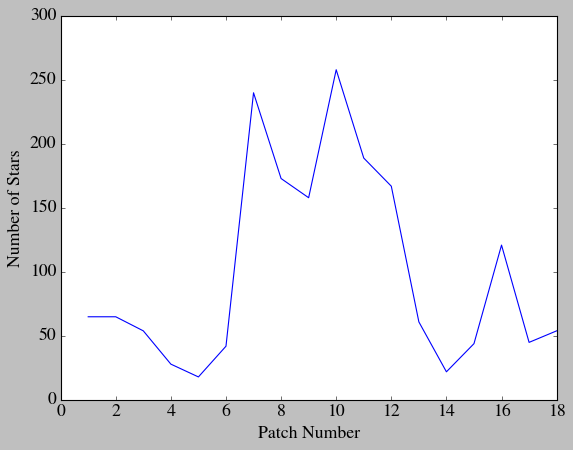

In [29]:
zmini = [20, 32, 44, 56, 68, 80]
plt.plot(range(1,len(numf[0][3])+1),numf[0][3])

#plt.plot(zmini,ratio,c='green',label='')
#plt.xlim(0,100)
plt.ylabel('Number of Stars')
plt.xlabel('Patch Number')

plt.show()

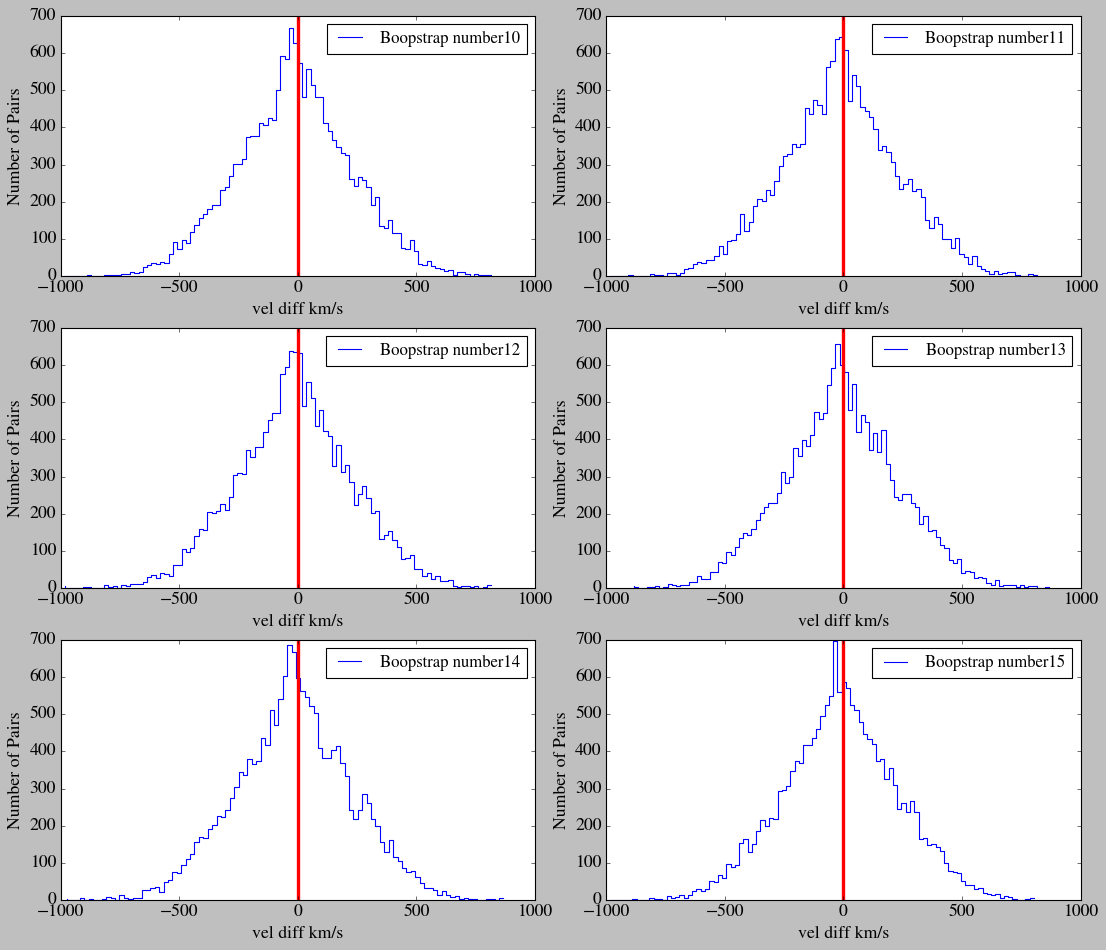

In [166]:
fig, ax = plt.subplots(3, 2, figsize=(15, 13), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=False, sharey=False)

fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
k = 10
    
degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
for index in range(ax.shape[0]):
    for jndex in range(ax.shape[1]):
        ax[index][jndex].step(testboop[1][1][k][:100],testboop[0][1][k],  label='Boopstrap number'+str(k))
            
        ax[index][jndex].axvline(0,linewidth = 3,c= 'r')
        ax[index][jndex].set_xlabel('vel diff km/s')
        ax[index][jndex].set_ylabel('Number of Pairs')
        ax[index][jndex].legend(loc=1, prop={'size': 15})
        
            
            
        k = k + 1
#plt.savefig('halo09_space_bound.png')            
plt.show()

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(18, 20), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=False, sharey=False)

fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
k = 0
    
degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
for index in range(ax.shape[0]):
    for jndex in range(ax.shape[1]):
        ax[index][jndex].hist(sep[k], bins=50, label='Number of the stars in the shell is '+str(num[k]))
            
        ax[index][jndex].axvline(6,linewidth = 3,c= 'r')
        ax[index][jndex].set_xlabel('Space Separation kpc')
        ax[index][jndex].set_ylabel('Number of Pairs')
        ax[index][jndex].legend(loc=1, prop={'size': 15})
        
            
            
        k = k + 1
plt.savefig('halo09_space_bound.png')            
plt.show()

In [191]:
zmini = [20, 26, 32, 38, 44, 60, 76]
zmaxi = [26, 32, 38, 44, 60, 76, 92]

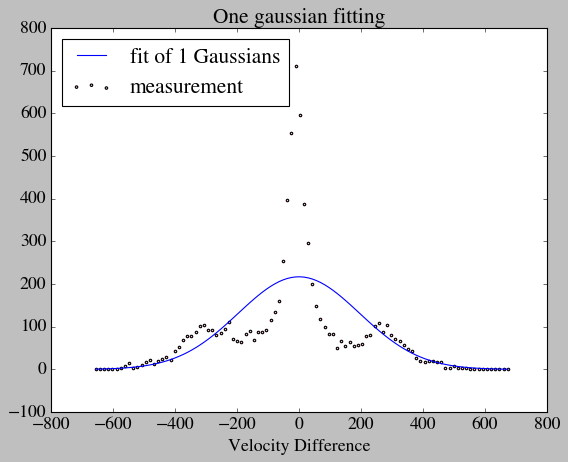

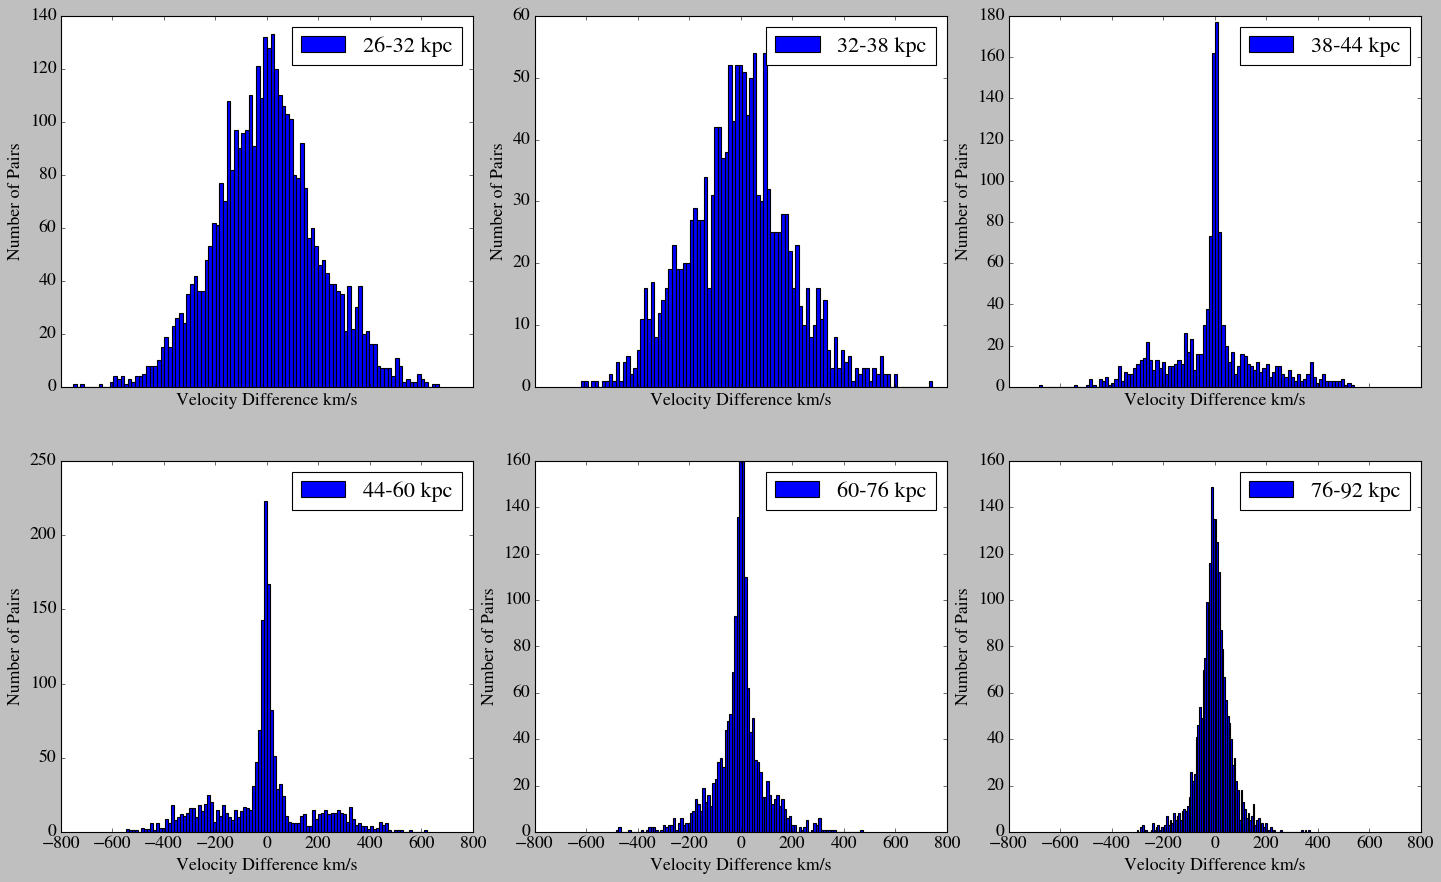

In [206]:
fig, ax = plt.subplots(2, 3, figsize=(20, 12), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=True, sharey=False)

fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
k = 1
sc = 0
degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
for index in range(ax.shape[0]):
    for jndex in range(ax.shape[1]):
        ax[index][jndex].hist(test1f[sc][k], bins=100, label=str(int(zmini[k])) +'-'+ str(int(zmaxi[k]))+' kpc')
            
        ax[index][jndex].set_xlim(-800,800)
        ax[index][jndex].set_xlabel('Velocity Difference km/s')
        ax[index][jndex].set_ylabel('Number of Pairs')
        ax[index][jndex].legend( prop={'size': 20})
        
            
            
        k = k + 1
plt.savefig('halo17_space_2_unbound.png')             
plt.show()

In [193]:
def one_gaussian(params,x,ydata):
    h1 = params[0]
    c1 = params[1]
    w1 = params[2]
    offset = params[3]
    
    #x,ydata = s6b[num][:100],s6h[num]
    ypred = gaussian(x, h1, c1, w1, offset) 
      
    LL = -np.sum(stats.poisson.logpmf(ydata, ypred))
    #LL = 0
    #for ii in range(0,len(ydata)):
        #print (math.factorial(ydata[ii]))
        #print (np.log(math.factorial(ydata[ii])))
        #print (math.factorial(ydata[ii]),ypred[ii],np.log(ypred[ii]))
        #LL = LL+np.log(np.asarray(math.factorial(ydata[ii])))+ypred[ii]-ydata[ii]*np.log(ypred[ii])
    return LL 



In [194]:
def two_gaussians(params,x,ydata):
    h1 = params[0]
    c1 = params[1]
    w1 = params[2]
    h2 = params[3]
    c2 =params[4]
    w2 =params[5]
    offset = params[6]
    sd = params[7]
    #x,ydata = s6b[num][:100],s6h[num]
    ypred = (gaussian(x, h1, c1, w1, offset=0) +
        gaussian(x, h2, c2, w2, offset=0)  + 
        offset)
    #LL = -np.sum(stats.norm.logpdf(ydata, loc=ypred, scale=sd) )
    LL = -np.sum(stats.poisson.logpmf(ydata, ypred))
    #LL = 0
    #for ii in range(0,len(ydata)):
        #print (math.factorial(ydata[ii]))
        #print (np.log(math.factorial(ydata[ii])))
        #print (math.factorial(ydata[ii]),ypred[ii],np.log(ypred[ii]))
        #LL = LL+np.log(np.asarray(math.factorial(ydata[ii])))+ypred[ii]-ydata[ii]*np.log(ypred[ii])
    return LL 
def gaussian(x, height, center, width, offset):
    return height*np.exp(-(x - center)**2/(2*width**2)) + offset

In [195]:
def two_gaussians_ra(x, h1, c1, w1, h2, c2, w2, offset):
    return (gaussian(x, h1, c1, w1, offset=0) +
        gaussian(x, h2, c2, w2, offset=0)  + 
        offset)

In [214]:
def fitting_final(data,ap1,c1, width1, ap2, c2, width2,offset,bins,plot):
    optim = []
    integrer = []
    fn = open("halo12_file2_06kpc_1.txt", "w")
    fn2 =  open("halo12_file1_06kpc_1.txt", "w")
    for ii in range(0,len(data)):
        datay, datax = np.histogram(data[ii][( data[ii]< 1000)  & (data[ii] > -1000)], density=False,bins=bins)
        optim1,optim2,aic1,aic2,ratio = fitting_result(datax[:100],datay,ap1,c1, width1, ap2,c2, width2,offset,0,bins,ii,plot)
        #optim.append(np.append(result,chisq))  
        
        
        #optim1,optim2,aic1,aic2,ratio = fitting_result(data[data.keys()[ii+1]][(data[data.keys()[ii+1]] > -1000) &( data[data.keys()[ii+1]] < 1000)],data[data.keys()[ii]][(data[data.keys()[ii+1]] > -1000) &( data[data.keys()[ii+1]] < 1000)],ap1,c1, width1, ap2,c2, width2,offset,0,bins,ii)
        #optim.append(np.append(result,chisq))
       # print (result)
        #if len(result) > 5:
        fn.write('& ' + str(np.round(aic1,2)) + '& ' +str(np.round(optim1[0],2))+'& '+str(np.round(optim1[1],2))+ '& '+str(np.round(optim1[2],2))+'& '+str(np.round(optim1[3],2)) + '& '
               +str(np.round(optim1[4],2))+'& '+str(np.round(optim1[5],2))+'&  '+str(np.round(ratio,2))+ "\\"+'\n')
        fn2.write('& ' + str(np.round(aic2,2)) + '& ' +str(np.round(optim2[0],2))+'& '+str(np.round(optim2[1],2))+ '& '+str(np.round(optim2[2],2))+ '&  '+str(np.round(ratio,2))
               + "\\"+'\n')
        #print (ratio)
    fn.close()
    fn2.close()
    return optim1,optim2,aic1,aic2,ratio


In [215]:
def fitting_result(x,y,h1,c1, w1, h2, c2, w2,offset,sd,bins,k,plot):
    
   

    guess6= [h1,c1, w1, h2, c2, w2,offset,sd]
    #LL = -np.sum(stats.norm.logpdf(ydata, loc=yPred, scale=sd) )
    bds1=((0, 9999), (-1000,1000), (0,50), (0,9999), (-1000,1000),(50,9999),(-9999,9999),(-9999,9999))
    optim1 = minimize(two_gaussians, guess6,args=(x,y),method = 'Nelder-Mead',bounds = bds1)
    optim2 = minimize(one_gaussian, [h1,c1, w1,offset,sd],method = 'Nelder-Mead',args=(x,y))
   
    #np.sum(((y-two_gaussians(x, *optim1))**2)/(poisson.std(50,loc=0)**2))/(bins-len(guess6))
    
    #chisq1 = chisquare(y,two_gaussians(x, *optim1))[0]
    #print (optim1.x)
    p1 = optim1.x
    optim1=p1
    ypred = (gaussian(x, p1[0], p1[1], p1[2], offset=0) +
        gaussian(x, p1[3], p1[4], p1[5], offset=0)  + 
        p1[6])
    LL1  = -np.sum(stats.poisson.logpmf(y, ypred))
    #chisq1 =  
    #print ('err',np.sqrt(np.diag(success1)))
    
   
    #np.sum(np.absolute((two_gaussians(x, *optim1) - y)**2/two_gaussians(x, *optim1)))
    #chisq2 = np.sum(((y-one_gaussian(x, *optim2))**2)/(poisson.std(1/2*np.max(y),loc=0)**2))/(bins-len(guess6))
    p2 = optim2.x
    #print (optim2.x)
    ypred2 = gaussian(x, p2[0], p2[1], p2[2],p2[3])
    LL2  = -np.sum(stats.poisson.logpmf(y, ypred2))
    optim2 =p2
    #atio = np.exp(7-4)*np.exp(LL1/LL2)
    aic1 = 2*LL1+14
    aic2 = 2*LL2+8
    bic1 = -2*np.log(LL1)+7*np.log(bins)
    bic2 = -2*np.log(LL2)+4*np.log(bins)
    #print (aic1,aic2)
    
    interen = integrate.quad(lambda x: gaussian(x,optim1[0],optim1[1],optim1[2],optim1[6]), -np.absolute((optim1[2]*3))+optim1[1],np.absolute(optim1[2]*3)+optim1[1])[0]
    #intereb = integrate.quad(lambda x: two_gaussians_ra(x, *optim1[:7]), -np.absolute((optim1[5]*3))+optim1[4], -np.absolute((optim1[2]*3))+optim1[1])[0]
    intereb = simps(y, dx=np.absolute(x[0]-x[1]))
    #print (intereb)
    ratio = interen/(intereb)
        
    #if (p1[0] > 0) & (p1[2] > 0) & (p2[0] > 0):
        #print ('two gaussian')
    #else:
        #print ('one gaussian')
    #print (str(k)+'&'+str(np.round(aic1,2))+'&'+str(np.round(aic2,2))+'&'+str(np.round(bic1,2))+'&'+str(np.round(bic2,2))+'\\')
    #print ('err',np.sqrt(np.diag(success2)))
    if plot == True:
        plt.scatter(x,y, c='pink', label='measurement', marker='.', edgecolors=None)
        plt.plot(x, ypred, c='b', label='fit of 2 Gaussians')
        plt.title("Two Gaussian Fitting")
        plt.ylabel("Number of pairs")
        plt.xlabel("Velocity Difference")
        plt.legend(loc='upper left')
        plt.savefig('halo12_2_2gaussian_fit'+str(k)+'06grav2.5_1.png')
        plt.show()
        plt.scatter(x,y, c='pink', label='measurement', marker='.', edgecolors=None)
        plt.plot(x, (gaussian(x, p2[0], p2[1], p2[2], p2[3])), c='b', label='fit of 1 Gaussians')
        plt.title("One gaussian fitting")
        plt.xlabel("Velocity Difference")
        plt.legend(loc='upper left')
        plt.savefig('halo12_2_1gaussian_fit'+str(k)+'06grav2.5_1.png')
        plt.show()
    
    #return 
    #np.sum(np.absolute((one_gaussian(x, *optim2) - y)**2/one_gaussian(x, *optim2)))
    #if np.absolute(aic1)-np.absolute(aic2) < 0:
        #return LL1,p1
    #else:
        #return LL2,p2
         
    #if np.absolute(chisq1) < np.absolute(chisq2):
        
        #interen = integrate.quad(lambda x: two_gaussians(x, *optim1), -np.absolute((optim1[2]*3))+optim1[1],np.absolute(optim1[2]*3)+optim1[1])[0]
        #intereb = integrate.quad(lambda x: two_gaussians(x, *optim1), -np.absolute((optim1[5]*3))+optim1[4], -np.absolute((optim1[2]*3))+optim1[1])[0]
        #ratio = interen/(2*intereb)
        
        #print ('test',interen,intereb,-optim1[2]*3+optim1[1], optim1[2]*3+optim1[1],-optim1[5]*3+optim1[4], -optim1[2]*3+optim1[1],ratio)
    
        #return optim1,chisq1,success1,ratio
    #else:
        #print (chisq2)
    return optim1,optim2,aic1,aic2,ratio

In [216]:
def fitting_final_boot(datax,datay,ap1,c1, width1, ap2, c2, width2,offset,bins,plot):
    optim1f = []
    optim2f = []
    aic1f = []
    aic2f = []
    #f = open("halo17_file2_100000.txt", "a")
    for ii in range(0,int(len(datax)),1):
        
        
        
        optim1,optim2,aic1,aic2,ratio = fitting_result(datax[ii][:100],datay[ii],ap1,c1, width1, ap2,c2, width2,offset,0,bins,ii,plot)
        optim1f.append(optim1)
        optim2f.append(optim2)
        aic1f.append(aic1)
        aic2f.append(aic2)
        #optim.append(np.append(result,chisq))
       # print (result)
        #if len(result) > 5:
            #f.write('& ' + str(np.round(chisq,2)) + '& ' +str(np.round(result[2],2))+'$\pm$'+str(np.round(np.sqrt(np.diag(success1))[2],2))+ '& '+str(np.round(result[5],2))+'$\pm$'+str(np.round(np.sqrt(np.diag(success1))[5],2)) + '& '
               #+str(np.round(result[0],2))+'$\pm$'+str(np.round(np.sqrt(np.diag(success1))[0],2)) + '& '+str(np.round(result[3],2))+'$\pm$'+str(np.round(np.sqrt(np.diag(success1))[3],2)) + '& '+str(np.round(result[1],2))+'$\pm$'+str(np.round(np.sqrt(np.diag(success1))[1],2)) + '& '
               #+str(np.round(result[4],2))+'$\pm$'+str(np.round(np.sqrt(np.diag(success1))[4],2)) + '& '+str(np.round(ratio,2))+ "\\"+'\n')
        
        #print (ratio)
    #f.close()
    return optim1f,optim2f,aic1f,aic2f

In [222]:
testboop = boopstrap_sat(test1f[1],0.9,2000,100)

In [223]:
testboopaic1 = []
testboopaic2 = []
for ii in range(0,len(testboop[1])):
    
    optim1f,optim2f,aic1f,aic2f = fitting_final_boot(testboop[1][ii],testboop[0][ii],5000,0, 30, 300,0, 200,0,100,False)
    testboopaic1.append(aic1f)
    testboopaic2.append(aic2f)





In [ ]:
testboopaic1[0][((np.array(testboopaic1[0])> -10) & (np.array(testboopaic1[0]) < 10))]

In [ ]:
mean= np.mean(testboopaic1[0])
len(testboopaic1[0]
while len(testboopaic1[0] > 10 
    

In [ ]:
len(testboopaic1)

In [68]:
def cal_con(aics,percent,step,n):
    upper =[]
    lower = []
    
    for ii in range(0,len(aics)):
        mean= np.median(aics[ii])
        print (mean)
        while (len(np.array(aics[ii])[(np.array(aics[ii])> mean - step) & (np.array(aics[ii]) < mean + step)]) < percent*len(aics[ii])):
        
        
            step=step+n
        
        upper.append(mean + step)
        lower.append(mean - step)
        #for kk in range(0,len(aics[ii])):
    return lower,upper      

In [ ]:
l,u = cal_con(testboopaic1,0.90,10,0.1)

In [ ]:
l,u

In [ ]:
import statsmodels.stats.api as sms

In [226]:
for k in range(0,len(testboopaic2)):
    
    #for jj in range(0,len(testboopaic1[k])):
    a = testboopaic2[k]
    print (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a)))
    #print (sms.DescrStatsW(a).tconfint_mean())

(811.417578912117, 814.0496870628631)
(816.792606714732, 819.6848510902697)
(796.5988342878429, 800.7298804624181)
(1496.0728956303665, 1502.0110462442399)
(3649.5973456197344, 3659.738183851572)
(1554.5004863957624, 1561.3553471186738)
(1060.257990535974, 1064.2715668148544)


In [227]:
for k in range(0,len(testboopaic1)):
    
    #for jj in range(0,len(testboopaic1[k])):
    a = testboopaic1[k]
    print (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a)))
    #print (sms.DescrStatsW(a).tconfint_mean())

(804.725113435797, 807.7601492003192)
(754.0251871213972, 756.4040366212113)
(774.0683948039101, 777.1156633280883)
(832.2457296046853, 836.2665907683263)
(1302.7769005919013, 1311.0522495029745)
(721.6923407681164, 726.452670709056)
(737.0881903488437, 739.958763462507)


In [ ]:
datay, datax = np.histogram(data[ii][( data[ii]< 1000)  & (data[ii] > -1000)], density=False,bins=bins)

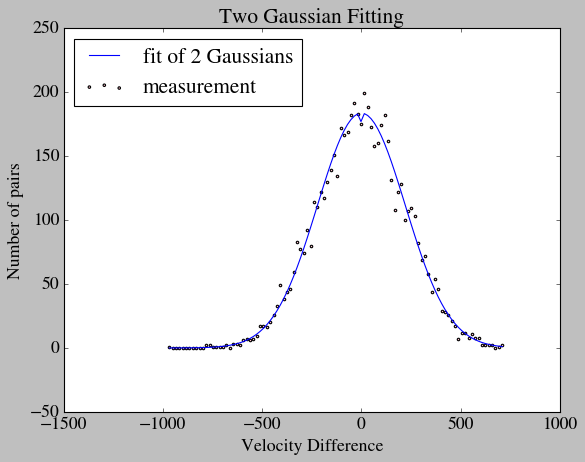

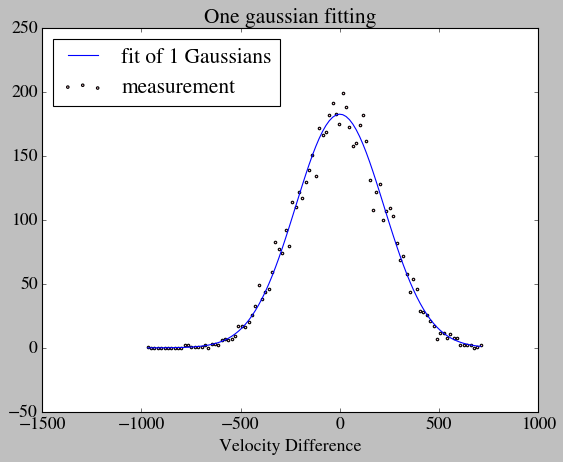

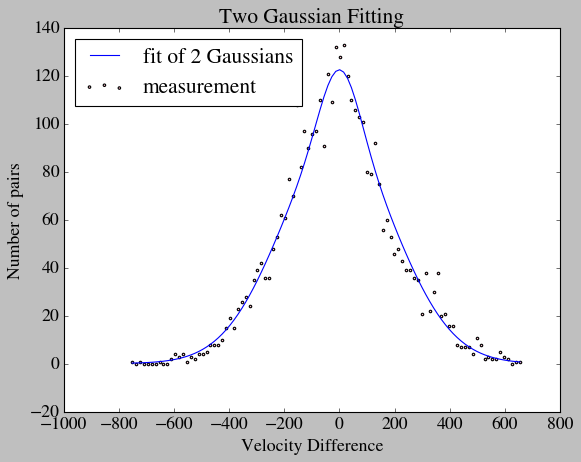

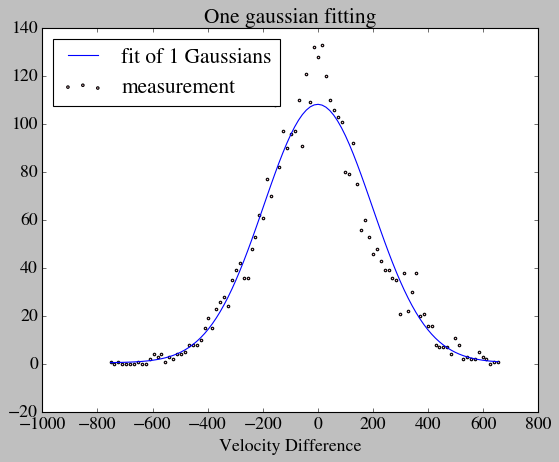

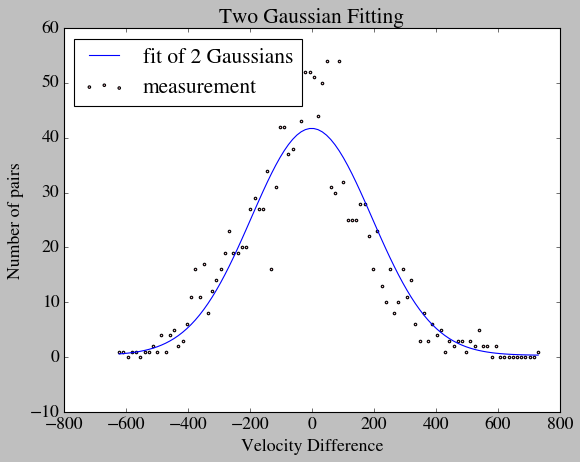

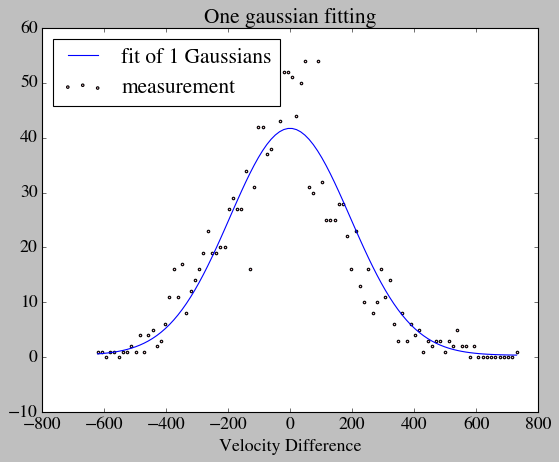

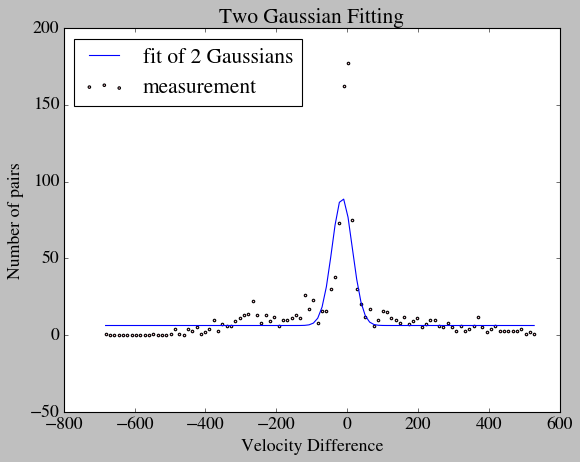

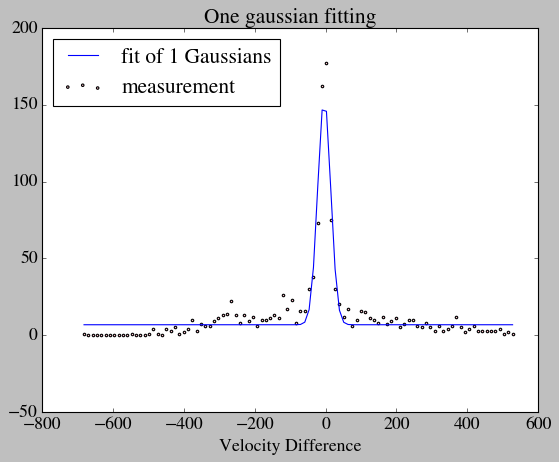

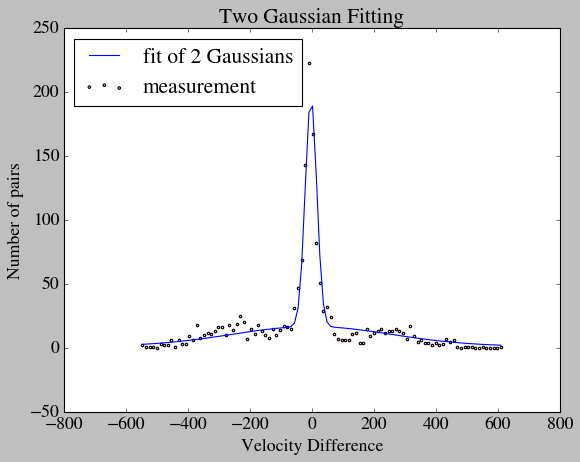

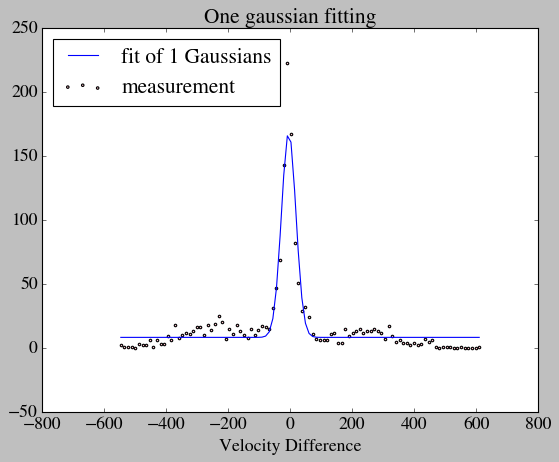

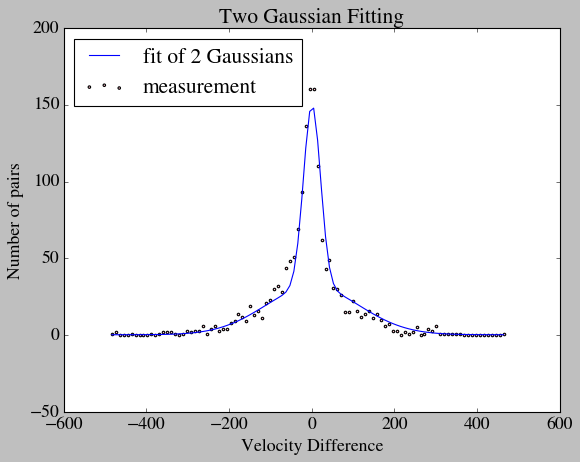

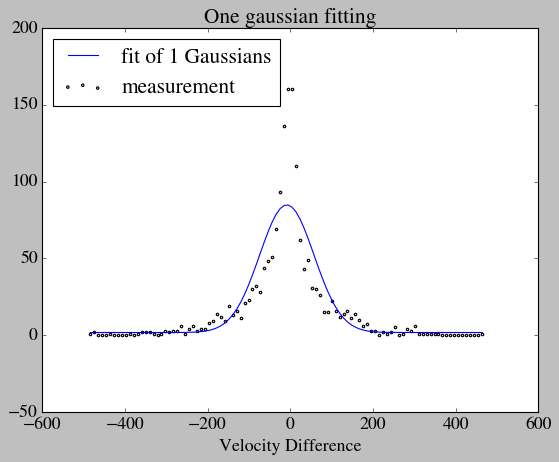

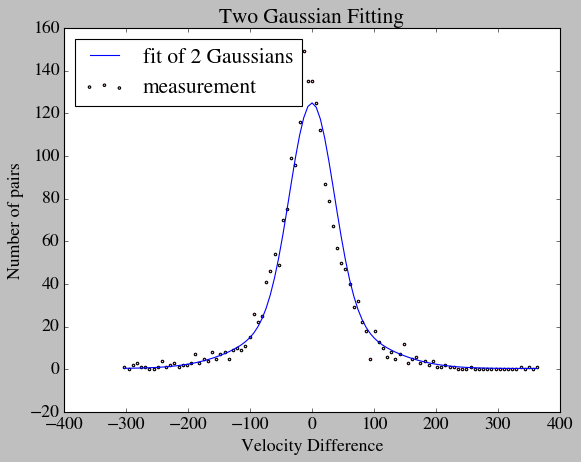

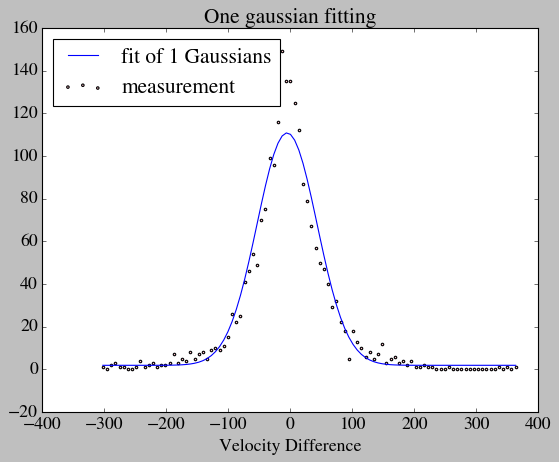

In [218]:
optim1f,optim2f,aic1f,aic2f,ratio = fitting_final(test1f[0],5000,0, 30, 300,0, 200,0,100,True)






In [ ]:
knum= np.array(numf[0][1])[np.array(numf[0][1])>10]
kindex = np.array(range(0,len(numf[0][1])))[np.isin(numf[0][1], knum)]
testmass1= stemass(np.array(indexf[0][1])[kindex],df3,groupidi,testd,1211,(1515-149))

In [ ]:
massnum =[]
totnum = []
for kk in range(0,len(testmass1[1])):
    
    massnumi=np.array(testmass1[1][kk])[np.nonzero(testmass1[1][kk])]
    totnumi = massnumi[testmass1[0][kk]>6e10]
    massnum.append(massnumi)
    totnum.append(np.sum(totnumi))

In [ ]:
a = np.histogram(testboopaic1[2], density=False,bins=100)

In [ ]:
sorted(testboopaic1[0])[-1]

In [ ]:
sms.DescrStatsW(a[1]).tconfint_mean()

#### plt.hist(testboopaic[2],bins=50)
plt.xlabel('Aic Measurement')
plt.ylabel('Number')
plt.show()

In [27]:
def gaussian_likelihood(leng):
    lowbu = []
    highbu = [] 
    lowbu2=[]
    highbu2= [] 
    for num in range(0,leng):
        guess6= [np.max(s6h[num]),0, 60, np.max(s6h[num])/2 , 0, 120,0,100] 
        x,ydata = s6b[num][:100],s6h[num]
    #LL = -np.sum(stats.norm.logpdf(ydata, loc=yPred, scale=sd) )
        optim1 = minimize(two_gaussians, guess6, method='Nelder-Mead',args=(x,ydata))
        p1 = optim1.x

        ypred = (gaussian(s6b[num][:100], p1[0], p1[1], p1[2], offset=0) +
            gaussian(s6b[num][:100], p1[3], p1[4], p1[5], offset=0)  + p1[6])

        LL = -np.sum(stats.poisson.logpmf(s6h[num], ypred))

        plt.scatter(s6b[num][:100],s6h[num], c='pink', label='measurement', marker='.', edgecolors=None)
        plt.plot(s6b[num][:100],(gaussian(s6b[num][:100], p1[0], p1[1], p1[2], offset=0) +gaussian(s6b[num][:100], p1[3], p1[4], p1[5], offset=0)  + 
        p1[6]), c='b', label='fit of 2 Gaussians')
        plt.title("Two gaussian fitting")
        plt.ylabel("Number of pairs")
        plt.xlabel("Velocity Difference")
        plt.legend(loc='upper left')
#plt.plot(np.array(xnum)[lowi:highi+1], np.array(newdiff)[lowi:highi+1],c='r')
#plt.plot(np.array(xnum2)[highi2:lowi2+1],np.array(newdiff2)[highi2:lowi2+1],c='r')
#plt.savefig('result.png')
        plt.show()
    
        diff = s6h[num]-(gaussian(s6b[num][:100], p1[0], p1[1], p1[2], offset=0) +
        gaussian(s6b[num][:100], p1[3], p1[4], p1[5], offset=0)  + 
        p1[6])
        width = p1[2]

#for ii in range(0,len(diff)):


        newdiff = diff[np.where(s6b[num][:100] > 3*width)]
        newdiff2 = diff[np.where(s6b[num][:100] < -3*width)]
        xnum = s6b[num][:100][np.where(s6b[num][:100] > 3*width)]
        xnum2 = s6b[num][:100][np.where(s6b[num][:100] <  -3*width)]
        lowi = np.array(range(0,100))[np.where(newdiff == np.min(newdiff))][0]
        highi = np.array(range(0,100))[np.where(newdiff == np.max(newdiff))][0]
        lowi2 = np.array(range(0,100))[np.where(newdiff2 == np.min(newdiff2))][0]
        highi2 = np.array(range(0,100))[np.where(newdiff2 == np.max(newdiff2))][0]


       # finaladd = np.append(np.array(newdiff2)[lowi2:highi2],np.array(newdiff)[lowi:highi])
        xnumf = np.append(np.array(xnum2)[lowi2:highi2],np.array(xnum)[lowi:highi])
#plt.plot(np.array(xnum2)[highi2:lowi2+1],np.array(newdiff2)[highi2:lowi2+1])
        plt.scatter(s6b[num][:100],s6h[num], c='pink', label='measurement', marker='.', edgecolors=None)
        plt.plot(s6b[num][:100],s6h[num]-(gaussian(s6b[num][:100], p1[0], p1[1], p1[2], offset=0) +
        gaussian(s6b[num][:100], p1[3], p1[4], p1[5], offset=0)  + 
        p1[6]), c='b', label='fit of gaussian Gaussians')
        plt.title("Two gaussian fitting")
        plt.ylabel("Number of pairs")
        plt.xlabel("Velocity Difference")
        plt.legend(loc='upper left')
        if (lowi < highi+1) &  (highi2 < lowi2+1) :
            plt.plot(np.array(xnum)[lowi:highi+1], np.array(newdiff)[lowi:highi+1],c='r')
            plt.plot(np.array(xnum2)[highi2:lowi2+1],np.array(newdiff2)[highi2:lowi2+1],c='r')
        else:
            
            lowb = lowi
            lowa = highi
            lowi = lowa
            highi = lowb
            
            lowb2 = lowi2
            lowa2 =highi2
            lowi2 = lowa2
            highi2 = lowb2
            plt.plot(np.array(xnum)[lowi:highi+1], np.array(newdiff)[lowi:highi+1],c='r')
            plt.plot(np.array(xnum2)[highi2:lowi2+1],np.array(newdiff2)[highi2:lowi2+1],c='r')
            
            
        print (lowi,highi+1,highi2,lowi2+1)
        plt.show()                        

        lowbu.append(xnum2[highi2])
        lowbu2.append(xnum2[lowi2])
        highbu.append(xnum[lowi])
        highbu2.append(xnum[highi])
        
    return lowbu,lowbu2,highbu,highbu2

    

In [ ]:
lowb,lowb2,highb,highb2 = gaussian_likelihood(4)

In [ ]:
lowb,lowb2,highb,highb2

In [ ]:
def load_index(vel_diff,indexf,lowv,highv,lowv2,highv2):
    indexstot = []
    narrowtotal = []
    overlaptot = []
    indexoutot = [ ]
  
    print(lowv,highv,lowv2,highv2)
    
   
    
    
    

    #indexcut = indexf[(((vel_diff > lowv) & (vel_diff < highv)) or ((vel_diff > lowv2) & (vel_diff < highv2)))] 
    indexcut = np.append(indexf[((vel_diff  > lowv) & (vel_diff < highv))], indexf[((vel_diff > lowv2) & (vel_diff < highv2))]) 
    
    indexout1 = np.append(indexf[(vel_diff < lowv)],indexf[(vel_diff > highv) & (vel_diff < lowv2)])
    
    indexout = np.append(indexout1,indexf[(vel_diff > highv2)])
    
    
    print (indexout)
    indexoutt = []
    indexs = []
    for item in indexout:
        indexoutt.append(int(item[:item.find('-')]))
        indexoutt.append(int(item[item.find('-')+1:]))

    indexoutot.append(indexoutt)
    for item in indexcut:
        indexs.append(int(item[:item.find('-')]))
        indexs.append(int(item[item.find('-')+1:]))
        
        
            
    overlap = []

    for item1 in np.unique(indexoutt):
        for item2 in np.unique(indexs):
            if item1 == item2:
                overlap.append(item2)
    totaln = []
    uniqueid =  []



    for ii in range(0,len(indexs)):
        n = 0 
        for item1 in overlap:
            if indexs[ii] == item1:
                n=n+1
      
      

        if n ==0:
        
            
            uniqueid.append(indexs[ii])
        totaln.append(n)
    indexstot.append(np.ravel(indexs))
    overlaptot.append(np.ravel(indexs)[np.isin(np.ravel(indexs),overlap)])
    narrowtotal.append(np.ravel(uniqueid))
    
    return indexoutot,indexstot,overlaptot,narrowtotal

In [ ]:
indexf[2][2]

In [ ]:
indexoutot,indexstot,overlaptot,narrowtotal = [],[],[],[]
for ii in range(0,4):

    indexoutoti,indexstoti,overlaptoti,narrowtotali = load_index(test1f[2][ii],indexf[2][ii],lowb[ii],lowb2[ii],highb[ii],highb2[ii])
    indexoutot.append(indexoutoti)
    indexstot.append(indexstoti)
    overlaptot.append(overlaptoti)
    narrowtotal.append(narrowtotali)


In [ ]:
plt.plot(test1f[2][2])
plt.show()

In [ ]:
#plotting narrow peak star satellite properties
def sate_narrow_plot(rlim,inputid,df3,totalstarid,totaldata,satlow,sathigh,radius,interval):
    data2=ebf.read('/Users/Jenny/thesis_idea_test/halo/galaxia/bj/'+'satprop.ebf') #reads in ebf file for galaxia output
    df=pd.DataFrame() #creates empty pandas DataFrame
    fig, ax = plt.subplots(2, 2, figsize=(20, 12), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=True, sharey=True)

    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
    k = 0
    
    degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
            
            staridf = df3['starid'][np.isin(df3['index'],np.ravel(inputid[k]))]
            

            satidunqiue = testd['satid'][np.isin(totalstarid,staridf)]

            satidcut = np.isin(np.arange(satlow,sathigh),np.unique(satidunqiue))
            
            print (satidunqiue)
            #print (staridf,satidunqiue)
            ax[index][jndex].scatter(data2['jsat'][satlow:sathigh][satidcut],data2['tsat'][satlow:sathigh][satidcut],marker='o', c='b',s=data2['msat'][satlow:sathigh][satidcut]/10E8, label=str(int(radius[k])) +'-'+ str(int(radius[k]+8))+'kpc')
            #ax[index][jndex].scatter(df3['x'],df3['y'],df3['z'],c='b',marker='o',s=1,alpha= 0.3,label = 'All stars in the sample')
            #ax[index][jndex].scatter(df4['x'],df4['y'],df4['z'],c='red',marker='^',label = 'Stars from |Vdiff| < 80 km/s in the sample ')
            

            ax[index][jndex].set_xlabel('Circularity')
            ax[index][jndex].set_ylabel('Accrected Time (Gyr)')
            ax[index][jndex].legend( prop={'size': 16})
        
            
            
            k = k + 1
#plt.savefig('halo17_space_2_unbound.png')             
    fig, ax = plt.subplots(2, 2, figsize=(20, 12), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=True, sharey=True)

    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
    k = 0
    
    degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
            
            staridf = df3['starid'][np.isin(df3['index'],df3['index'][(rlim[k] < df3['r']) & (df3['r']<rlim[k]+interval )])]

            satidunqiue = testd['satid'][np.isin(totalstarid,staridf)]

            satidcut = np.isin(np.arange(satlow,sathigh),np.unique(satidunqiue))
            
            #print (staridf,satidunqiue)
            ax[index][jndex].scatter(data2['jsat'][satlow:sathigh][satidcut],data2['tsat'][satlow:sathigh][satidcut],marker='o', c='b',s=data2['msat'][satlow:sathigh][satidcut]/10E8, label=str(int(radius[k])) +'-'+ str(int(radius[k]+8))+'kpc')
            #ax[index][jndex].scatter(df3['x'],df3['y'],df3['z'],c='b',marker='o',s=1,alpha= 0.3,label = 'All stars in the sample')
            #ax[index][jndex].scatter(df4['x'],df4['y'],df4['z'],c='red',marker='^',label = 'Stars from |Vdiff| < 80 km/s in the sample ')
            

            ax[index][jndex].set_xlabel('Circularity')
            ax[index][jndex].set_ylabel('Accrection Time (Gyr)')
            ax[index][jndex].legend( prop={'size': 16})
        
            
            
            k = k + 1
    plt.show()
    
        
        
             
        
        
        
            
            
        
        
        
        
        
    
    
        
   
        
        

In [ ]:
#plotting narrow peak star satellite properties
def sate_narrow_plot_2(rlim,inputid,df3,totalstarid,totaldata,satlow,sathigh,radius,interval):
    data2=ebf.read('/Users/Jenny/thesis_idea_test/halo/galaxia/bj/'+'satprop.ebf') #reads in ebf file for galaxia output
    df=pd.DataFrame() #creates empty pandas DataFrame
    fig, ax = plt.subplots(2, 3, figsize=(20, 12), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=True, sharey=True)

    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
    k = 0
    
    degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
            satmass = [] 
            satmass2 = []
            staridf = df3['starid'][np.isin(df3['index'],np.ravel(inputid[k]))]
            satidunqiue = testd['satid'][np.isin(totalstarid,staridf)]
            sattot = np.arange(satlow,sathigh)
            
            staridf2 = df3['starid'][np.isin(df3['index'],df3['index'][(rlim[k] < df3['r']) & (df3['r']<rlim[k]+interval )])]

            satidunqiue2 = testd['satid'][np.isin(totalstarid,staridf2)]

            satidcut2 = np.isin(np.arange(satlow,sathigh),np.unique(satidunqiue2))
            print (len(data2['msat'][satlow:sathigh][satidcut2]))
            for kk in range(0,len(sattot)):
                satmass.append(data2['msat'][satlow:sathigh][kk]*len(satidunqiue[satidunqiue==sattot[kk]]))
                satmass2.append(data2['msat'][satlow:sathigh][kk]*len(satidunqiue2[satidunqiue2==sattot[kk]]))
                           
                                           

                     #satidunqiue = testd['satid'][np.isin(totalstarid,staridf)]

            satidcut = np.isin(np.arange(satlow,sathigh),satidunqiue)
            #print (len(np.ravel(np.nonzero(satmass))))
            
            #print (np.ravel(satmass)/10**12-np.ravel(satmass2)/10**12)
            ax[index][jndex].scatter(data2['jsat'][satlow:sathigh],data2['tsat'][satlow:sathigh],marker='o', c='b',s=(np.absolute(np.ravel(satmass)-np.ravel(satmass2)))/10**11, label=str(int(radius[k])) +'-'+ str(int(radius[k]+8))+'kpc')
            #ax[index][jndex].scatter(df3['x'],df3['y'],df3['z'],c='b',marker='o',s=1,alpha= 0.3,label = 'All stars in the sample')
            #ax[index][jndex].scatter(df4['x'],df4['y'],df4['z'],c='red',marker='^',label = 'Stars from |Vdiff| < 80 km/s in the sample ')
            

            ax[index][jndex].set_xlabel('Circularity')
            ax[index][jndex].set_ylabel('Accrected Time (Gyr)')
            ax[index][jndex].legend( prop={'size': 16})
        
            
            
            k = k + 1
    #plt.show()
    fig, ax = plt.subplots(2, 3, figsize=(20, 12), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=True, sharey=True)

    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
    j=0
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
            satmass = [] 
            satmass2 = []
            staridf = df3['starid'][np.isin(df3['index'],np.ravel(inputid[j]))]
            satidunqiue = testd['satid'][np.isin(totalstarid,staridf)]
            sattot = np.arange(satlow,sathigh)
            
            staridf2 = df3['starid'][np.isin(df3['index'],df3['index'][(rlim[j] < df3['r']) & (df3['r']<rlim[j]+interval )])]

            satidunqiue2 = list(set(testd['satid'][np.isin(totalstarid,staridf2)])-set(testd['satid'][np.isin(totalstarid,staridf)]))
            satidunqiue3 = testd['satid'][np.isin(totalstarid,staridf2)][np.isin(testd['satid'][np.isin(totalstarid,staridf2)],satidunqiue2)]
            #satidcut2 = testd['satid'][np.isin(totalstarid,staridf2)][np.isin(testd['satid'][np.isin(totalstarid,staridf2)],np.unique(satidunqiue2))]
            #print (len(satidunqiue),len(satidunqiue3))
            for kk in range(0,len(sattot)):
                satmass.append(data2['msat'][satlow:sathigh][kk]*len(satidunqiue[satidunqiue==sattot[kk]]))
                satmass2.append(data2['msat'][satlow:sathigh][kk]*len(np.array(satidunqiue3)[satidunqiue3==sattot[kk]]))
                           
                                           

                     #satidunqiue = testd['satid'][np.isin(totalstarid,staridf)]

            satidcut = np.isin(np.arange(satlow,sathigh),satidunqiue)
            #print (np.ravel(satmass2)-np.ravel(satmass))
            
        
            #ax[index][jndex].scatter(data2['tsat'][satlow:sathigh], np.ravel(satmass)/np.ravel(satmass2)*100000, label=str(int(radius[j])) +'-'+ str(int(radius[j]+8))+'kpc')
            #ax[index][jndex].scatter(df3['x'],df3['y'],df3['z'],c='b',marker='o',s=1,alpha= 0.3,label = 'All stars in the sample')
            #ax[index][jndex].scatter(df4['x'],df4['y'],df4['z'],c='red',marker='^',label = 'Stars from |Vdiff| < 80 km/s in the sample ')
            
            ax[index][jndex].scatter(data2['jsat'][satlow:sathigh],data2['tsat'][satlow:sathigh],marker='o', c='b',s=(np.absolute(np.ravel(satmass)-np.ravel(satmass2)))/10**11, label=str(int(radius[j])) +'-'+ str(int(radius[j]+8))+'kpc')
            ax[index][jndex].set_xlabel('Circularity')
            ax[index][jndex].set_ylabel('Accrected Time (Gyr)')
            ax[index][jndex].legend( prop={'size': 16})
        
            
            
            j = j + 1
    plt.show()
#plt.savefig('halo17_space_2_unbound.png')             
 

In [ ]:
sate_narrow_plot_2(rlim,finalid,df3,groupidi,testd,1211,(1515-149),rlimf[2],8)

In [ ]:
sate_narrow_plot(rlim,indexstot,df3,groupidi,testd,1211,(1515-149),rlimf[2],8)

In [ ]:
threed_narrow_plot(indexstot,df3)

In [ ]:
#plotting narrow peak star position properties
def twod_narrow_plot(inputid,df3,radius):
    data2=ebf.read('/Users/Jenny/thesis_idea_test/halo/galaxia/bj/'+'satprop.ebf') #reads in ebf file for galaxia output
    df=pd.DataFrame() #creates empty pandas DataFrame
    
    fig, ax = plt.subplots(2, 2, figsize=(20, 18), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=True, sharey=False)
    #ax = fig.add_subplot(111,projection='3d')
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
    k = 0
    
    degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
            
            dff = df3[df3['index'].isin(np.unique(inputid[k]))]
            ax[index][jndex].scatter(df3['y'],df3['z'],c='b',marker='o',s=1,alpha= 0.3,label = 'All stars in the sample')
            ax[index][jndex].scatter(dff['y'],dff['z'],c='red',marker='^',label = 'Stars from |Vdiff| < 80 km/s in the sample '+str(int(radius[k])) +'-'+ str(int(radius[k]+8))+' kpc')

            
            ax[index][jndex].set_xlabel('Y (Kpc)')
            ax[index][jndex].set_ylabel('Z (Kpc)')
            #ax[index][jndex].set_zlabel('Z Label')
            ax[index][jndex].set_ylim(-75,75)
            ax[index][jndex].set_xlim(-75,75)
            #ax[index][jndex].set_zlim(-75,75)
            ax[index][jndex].legend(loc=4,prop={'size': 13})

        
            
            
            k = k + 1
#plt.savefig('halo17_space_2_unbound.png')             
    plt.show()
    

In [ ]:
#plotting narrow peak star histogram properties
def threed_narrow_hist(inputidal,inputidol,inputidna):
    data2=ebf.read('/Users/Jenny/thesis_idea_test/halo/galaxia/bj/'+'satprop.ebf') #reads in ebf file for galaxia output
    df=pd.DataFrame() #creates empty pandas DataFrame
    #subplot_args = {'projection':'3d'}
    fig, ax = plt.subplots(2, 2, figsize=(20, 12), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=True)
    #ax = fig.add_subplot(111,projection='3d')
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
    k = 0
    
    degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
            
            
            ax[index][jndex].hist(np.ravel((inputidal[k])),bins=60,color='r',label = 'All ID found inside narrow peak')
            ax[index][jndex].hist(np.ravel(inputidal[k])[np.isin(np.ravel(inputidal[k]),inputidol[k])],bins=60,alpha=0.5,color='g',label = 'ID found outside narrow peak')
            ax[index][jndex].hist(np.ravel(inputidna[k]),bins=60,label = 'ID found only inside narrow peak',color = 'blue', alpha = 0.3)
            
            ax[index][jndex].set_xlabel('Star-ID')
            ax[index][jndex].set_ylabel('Number')
            

           
    
            ax[index][jndex].legend(prop={'size': 16})

        
            
            
            k = k + 1
#plt.savefig('halo17_space_2_unbound.png')             
    plt.show()
    

In [ ]:
threed_narrow_hist(indexstot,overlaptot,narrowtotal)

In [ ]:
a= [1,1,1,1,2,2,2,2,3,3,4,5,5]
from itertools import groupby
[len(list([])) for key, group in groupby(a)]

In [ ]:
len(np.sort(indexoutot[0]))

In [ ]:
#plotting narrow peak star histogram properties
def threed_narrow_hist(inputidal,indexoutot):
    
    
    
    
    #idtotal = df3['index'][(rlim[k] < df3['r']) & (df3['r']<rlim[k]+interval )]
    #subplot_args = {'projection':'3d'}
    fig, ax = plt.subplots(2, 2, figsize=(20, 12), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=True)
    #ax = fig.add_subplot(111,projection='3d')
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
    k = 0
    finalid = []
    degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
            
            outfre = []
            unique_id, counts_elements = np.unique(inputidal[k], return_counts=True)
            
            for item in unique_id:
                nn = 0
                for item2 in indexoutot[k]:
                    print (indexoutot[k])
                    if item == item2:
                        nn=nn+1
                outfre.append(nn)
            
            
            finalid.append(unique_id[(counts_elements-outfre) > 0])
            
    
    
            #outfre = [len(list(unique_id)) for key, group in groupby(indexoutot[k])]
            #print (len(unique_id), len(counts_elements),len(indexoutot[k]))
            
            #ax[index][jndex].plot(unique_id,counts_elements-outfre,c='r',label = 'Difference between two frequency')
            #ax[index][jndex].plot(unique_id,outfre)
            
            #ax[index][jndex].set_xlabel('Star-ID')
            #ax[index][jndex].set_ylabel('Count Number')
            

           
    
            #ax[index][jndex].legend(prop={'size': 16})

        
            
            
            k = k + 1
#plt.savefig('halo17_space_2_unbound.png')             
    plt.show()
    
    return finalid 
    

In [ ]:
len(np.ravel(indexoutot)[1])

In [ ]:
len(np.ravel(indexstot)[0])

In [ ]:
 finalid  = threed_narrow_hist(np.ravel(indexstot)[:2],np.ravel(indexoutot)[:2])

In [1]:
inputidal= np.ravel(indexstot)[3]
outfre = []
unique_id, counts_elements = np.unique(inputidal, return_counts=True)
finalid4 = []
for item in unique_id:
    nn = 0
    for item2 in np.ravel(indexoutot)[3]:
        #print (item2)
        if item == item2:
            nn=nn+1
    outfre.append(nn)
            
            
finalid4.append(unique_id[(counts_elements-outfre) > 0])
            
    
    
            #outfre = [len(list(unique_id)) for key, group in groupby(indexoutot[k])]
    #print (len(unique_id), len(counts_elements),len(indexoutot))
            
plt.plot(unique_id,counts_elements-outfre,c='r',label = 'Difference between two frequency')
            #ax[index][jndex].plot(unique_id,outfre)
            
plt.xlabel('Star-ID')
plt.ylabel('count Number')
            
         

           
    
plt.legend(prop={'size': 16})

        
            
            
      
#plt.savefig('halo17_space_2_unbound.png')             
plt.show()
    
 
    

NameError: name 'np' is not defined

In [ ]:
outfre = []
unique_id, counts_elements = np.unique(inputidal, return_counts=True)
finalid4 = []
for item in unique_id:
    nn = 0
    for item2 in np.ravel(indexoutot)[3]:
        #print (item2)
        if item == item2:
            nn=nn+1
    outfre.append(nn)
            
            
finalid4.append(unique_id[(counts_elements-outfre) > 0])
            
    
    
            #outfre = [len(list(unique_id)) for key, group in groupby(indexoutot[k])]
    #print (len(unique_id), len(counts_elements),len(indexoutot))
            
plt.plot(unique_id,counts_elements-outfre,c='r',label = 'Difference between two frequency')
            #ax[index][jndex].plot(unique_id,outfre)
            
plt.xlabel('Star-ID')
plt.ylabel('count Number')
            
         

           
    
plt.legend(prop={'size': 16})

        
            
            
      
#plt.savefig('halo17_space_2_unbound.png')             
plt.show()
    
 
    

In [ ]:
finaid = [finalid[0],finalid2[0],finalid3[0],finalid4[0]]

In [22]:
def stemass(inputid,df3,totalstarid,testd,satlow,sathigh):
    data2=ebf.read('/Users/Jenny/thesis_idea_test/halo/galaxia/bj/'+'satprop.ebf')
    satmasst=[]
    numst=[]
    for ii in range(0,len(inputid)):
        staridf = df3['starid'][np.isin(df3['index'],np.ravel(inputid[ii]))]
            

        satidunqiue = testd['satid'][np.isin(totalstarid,staridf)]
        sattot = np.arange(satlow,sathigh)
        satidcut = np.isin(np.arange(satlow,sathigh),np.unique(satidunqiue))
       
        nums=[]
        for kk in range(0,len(sattot)):
            
            nums.append(len(satidunqiue[satidunqiue==sattot[kk]]))
        satmasst.append(data2['msat'][satlow:sathigh][satidcut])
        numst.append(nums)
    return satmasst,numst

In [30]:
def mass_fraction(numf,df3,groupidi,testd,satlow,sathigh):
    
    
    masstf=[]
    totnumf = []
    for ii in range(0,len(numf[0])):
        
        mass_frac=[]
        knum= np.array(numf[0][ii])[np.array(numf[0][ii])>10]
        kindex = np.array(range(0,len(numf[0][ii])))[np.isin(numf[0][ii], knum)]
        testmass1= stemass(np.array(indexf[0][ii])[kindex],df3,groupidi,testd,satlow,sathigh)
        print (len(knum))
        massnum =[]
        totnum = []
        for kk in range(0,len(testmass1[1])):
    
            massnumi=np.array(testmass1[1][kk])[np.nonzero(testmass1[1][kk])]
            totmassi = massnumi
            massnum.append(massnumi)
            #totnum.append(np.sum(totnumi))
        
        massi = massnum*np.array(testmass1[0])
        #print (len(massi))
        for jj in range(0,len(massi)):
            mass_frac.append(massi[jj]/np.sum(massi[jj]))
            totnum.append(massnum[jj]/np.sum(massnum[jj]))
        #masst.append(mass_frac)
        masstf.append(mass_frac)
        totnumf.append(totnum)
        #mass_frac.append(np.sum(totnum)/sum(knum))
    return masstf,totnumf

In [31]:
mass_frac=mass_fraction(numf,df3,groupidi,testd,113,215)

45
43
42
18


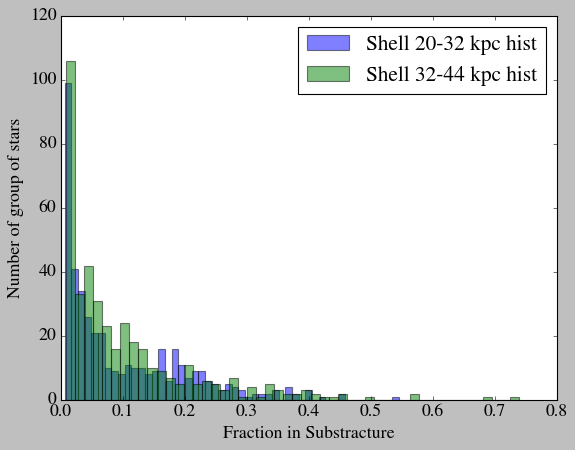

In [44]:
plt.hist(np.concatenate(mass_frac[1][0]),bins=50,label = 'Shell 20-32 kpc hist',alpha = 0.5)
plt.hist(np.concatenate(mass_frac[1][1]),bins=50,label = 'Shell 32-44 kpc hist',alpha = 0.5)
#plt.hist(np.concatenate(mass_frac[2]),bins=100,label = 'Shell 44-56 kpc hist',alpha = 0.5)
#plt.hist(np.concatenate(mass_frac[3]),bins=100,label = 'Shell 56-90 kpc hist',alpha = 0.5)
plt.ylabel('Number of group of stars')
plt.xlabel('Fraction in Substracture')
#plt.xlim(0.0,1)
#plt.ylim(0.,90)
plt.legend()
plt.show()
    

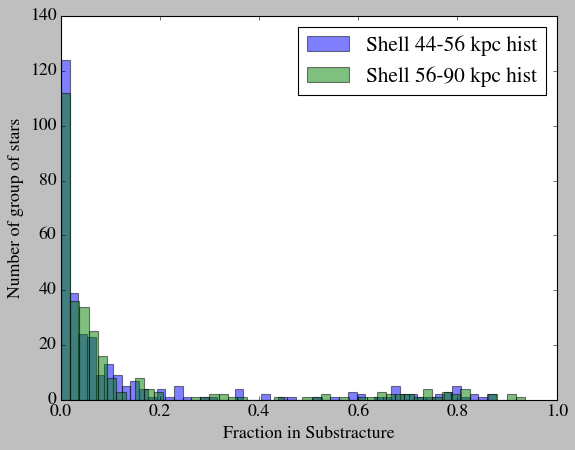

In [37]:
plt.hist(np.concatenate(mass_frac[2]),bins=50,label = 'Shell 44-56 kpc hist',alpha = 0.5)
plt.hist(np.concatenate(mass_frac[3]),bins=50,label = 'Shell 56-90 kpc hist',alpha = 0.5)
#plt.hist(np.concatenate(mass_frac[2]),bins=100,label = 'Shell 44-56 kpc hist',alpha = 0.5)
#plt.hist(np.concatenate(mass_frac[3]),bins=100,label = 'Shell 56-90 kpc hist',alpha = 0.5)
plt.ylabel('Number of group of stars')
plt.xlabel('Fraction in Substracture')
#plt.xlim(0.0,1)
#plt.ylim(0.,90)
plt.legend()
plt.show()

In [ ]:
zmini = [20, 32, 44, 56]
zmaxi = [32, 44, 56, 90]

In [32]:
ratio = []
for kk in range(0,4):
    
    ratio.append(len(np.concatenate(mass_frac[1][kk])[np.concatenate(mass_frac[1][kk])>0.2])/len(np.concatenate(mass_frac[1][kk])))
                 
                 
                 

In [33]:
ratio

[0.16818181818181818,
 0.15892420537897312,
 0.22857142857142856,
 0.16756756756756758]

# len(np.concatenate(mass_frac[1][0])[np.concatenate(mass_frac[1][0])>0.2])/len(np.concatenate(mass_frac[1][0]))

# Stellar Mass of Satellites

In [ ]:
len(data2['msat'])

In [ ]:
plt.hist(data2['msat'][1211:(1515-149)],bins=50)
plt.xlabel('Satellite Mass')
plt.ylabel('Number')
plt.show()

In [ ]:
plt.hist(data2['msat'][1211:(1515-149)][data2['msat'][1211:(1515-149)] < 0.4e11],bins=50)
plt.xlabel('Satellite Mass')
plt.ylabel('Number')
plt.show()